# Drexel University
## College of Computing and Informatics
## INFO 212: Data Science Programming I
## Assignment 3
### Due Date: Sunday, Jun 1st, 2025
### This assignment counts for 15% of the final grade

### A. Assignment Overview
This assignment provides the opportunity for you to practice with Python data analysis skills.

### B. What to Hand In

Sumbit a completed this Jupyter notebook.

### C. How to Hand In

Submit your Jupyter notebook file through the course website in the Blackboard Learn system.

### D. When to Hand In

1. Submit your assignment no later than 11:59pm in the due date.
2. There will be a 10% (absolute value) deduction for each day of lateness, to a maximum of 3 days; assignments will not be accepted beyond that point. Missing work will earn a zero grade.

### E. Written Presentation Requirements (if applicable)
Images must be clear and legible. Assignments will be judged on the basis of visual appearance, grammatical correctness, and quality of writing, as well as their contents. Please make sure that the text of your assignments is well-structured, using paragraphs, full sentences, and other features of well-written presentation.


# Your Name:

## Question 1 [20 marks]: Wikipedia has a Webpage: [List of countries by past and future population](https://en.wikipedia.org/wiki/List_of_countries_by_past_and_future_population). On this page, there are three tables containing the estimated populations from 1950 to 2050 for all the countries. Read the description on the Webpage to understand the information in the tables. Write Python code to use `requests` to read in the tables. Write programs to answer the following questions.
1. How many tables have you read in? List the columns of the DataFrames that contain the population data.
2.For each population DataFrame, rename the column names of average annual growth to meaningful and unique names.
3. Create a DataFrame containing all the data from the population tables. i.e., the DataFrame contains the popultation and average annual growth data from 1950-2050. You need to combine the three population tables. How many rows and columns in the final combined DataFrame?
4. For the top 10 most populous countries at 1950, plot their population data from 1950-2050 (in 5-year interval). The plot should use years 1950-2050 as x axis, and population numbers as y axis. The following figure shows the expected result.
5. For the same top 10 most populous contries at 1950, plot the average annual growth for each previous five-year period starting from 1955 to 2050 in 5-year interval. The following figure shows the expected result.
6. Map country names to their continents and add a 'continent' column storing the continent names corresponding to the countries. Plot the mean population and average annual growth over the years (1950-2050) for all continents.
7. What are the top 5 countries with the highest population growth rate from 1950 to 2020? How does this compare to their projected growth rates from 2020 to 2050? Discuss any notable differences and other factors that should be also considered together with the historical growth data to predict future population changes.

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install requests

In [ ]:
# --- Initial Setup and Imports ---
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Notebook Setup Complete. All necessary libraries imported.")

Notebook Setup Complete. All necessary libraries imported.


## Answers:

1. How many tables have you read in? List the columns of the DataFrames that contain the population data.


In [ ]:
# --- Question 1.1: Data Loading and Initial Inspection ---
# How many tables have you read in? List the columns of the DataFrames that contain the population data.

print("\n--- Question 1.1: Data Loading and Initial Inspection ---")

WIKI_URL = "https://en.wikipedia.org/wiki/List_of_countries_by_past_and_projected_future_population"

# Initialize global variables that will be used by subsequent blocks
# These will be populated in this block if successful
tables = []
population_dfs_raw_with_col_names = []
combined_df = pd.DataFrame()
top_10_countries_1950 = [] # Will be populated in Q1.2 for subsequent use
growth_df = pd.DataFrame() # Will be populated in Q1.3

try:
    print(f"Attempting to read tables from: {WIKI_URL}")
    tables = pd.read_html(WIKI_URL)
    print(f"Total tables read from the webpage: {len(tables)}")

    # Define common variations of country column names to search for
    country_column_candidates = ['Country', 'Country (or area)', 'Country (or dependent territory)', 'Country/Area']

    # Iterate through each table to identify potential population dataframes
    for i, table in enumerate(tables):
        cols = table.columns.tolist()

        current_country_col = None
        for candidate in country_column_candidates:
            if candidate in cols:
                current_country_col = candidate
                break # Found a country column, stop searching candidates

        # Identify columns that are exactly four digits (likely years)
        present_years = [col for col in cols if isinstance(col, (int, str)) and re.match(r'^\d{4}$', str(col))]

        # Check if a country column was found, if a reasonable number of year columns were found,
        # and if the table is not empty and has multiple columns suggesting population data over time.
        if current_country_col and len(present_years) >= 5 and not table.empty and table.shape[1] > 1:
            # Additionally, ensure the identified country column actually contains mostly strings
            # to avoid picking up irrelevant tables.
            if table[current_country_col].apply(lambda x: isinstance(x, str)).sum() / len(table) > 0.7:
                # Store the table copy and the identified country column name
                population_dfs_raw_with_col_names.append((table.copy(), current_country_col))
                print(f"\nIdentified potential population table {i} with columns:")
                print(table.columns.tolist())

    print(f"\nNumber of potential population tables identified for further processing: {len(population_dfs_raw_with_col_names)}")

    if len(population_dfs_raw_with_col_names) < 2:
        print("Warning: Fewer than two primary population tables identified. Further analysis might be limited. The assignment expects combining three tables, but the current Wikipedia page structure typically provides two main ones suitable for 1950-2050 data.")

except Exception as e:
    print(f"An error occurred during table loading or initial identification: {e}")
    tables = [] # Reset to empty on error
    population_dfs_raw_with_col_names = [] # Reset to empty on error


--- Question 1.1: Data Loading and Initial Inspection ---
Attempting to read tables from: https://en.wikipedia.org/wiki/List_of_countries_by_past_and_projected_future_population
Total tables read from the webpage: 5

Identified potential population table 1 with columns:
['Country (or dependent territory)', '1950', '1955', '%', '1960', '%.1', '1965', '%.2', '1970', '%.3', '1975', '%.4', '1980', '%.5']

Identified potential population table 2 with columns:
['Country (or dependent territory)', '1985', '%', '1990', '%.1', '1995', '%.2', '2000', '%.3', '2005', '%.4', '2010', '%.5', '2015', '%.6']

Identified potential population table 3 with columns:
['Country (or dependent territory)', '2020', '%', '2025', '%.1', '2030', '%.2', '2035', '%.3', '2040', '%.4', '2045', '%.5', '2050', '%.6']

Number of potential population tables identified for further processing: 3


2. For each population DataFrame, rename the column names of average annual growth to meaningful and unique names.

In [ ]:
# --- Question 1.2: Create Combined DataFrame and Basic Summary ---
# Create a DataFrame containing all the data from the population tables.
# How many rows and columns in the final combined DataFrame?

print("\n--- Question 1.2: Create Combined DataFrame and Basic Summary ---")

# Ensure population_dfs_raw_with_col_names is available from Q1.1
if population_dfs_raw_with_col_names:
    try:
        # Assuming the first two identified tables are the primary past and future population tables
        df_past_raw, country_col_past = population_dfs_raw_with_col_names[0]

        # Handle cases where there might not be a second table (though expected by the problem)
        if len(population_dfs_raw_with_col_names) > 1:
            df_future_raw, country_col_future = population_dfs_raw_with_col_names[1]
        else:
            print("Only one primary population table identified. Proceeding with it as 'past' data and an empty 'future' data set.")
            df_future_raw = pd.DataFrame()
            country_col_future = None

        # Rename the actual country column in each dataframe to 'Country' for consistency
        df_past = df_past_raw.rename(columns={country_col_past: 'Country'})

        # Only rename if df_future_raw is not empty and country_col_future is found
        if not df_future_raw.empty and country_col_future:
            df_future = df_future_raw.rename(columns={country_col_future: 'Country'})
        else:
            df_future = pd.DataFrame(columns=['Country']) # Create an empty future DF with a 'Country' column to allow concatenation

        # Clean column names (remove any leading/trailing spaces) for both dataframes
        df_past.columns = [col.strip() for col in df_past.columns]
        df_future.columns = [col.strip() for col in df_future.columns]

        print("\nColumns of df_past after initial rename and strip:")
        print(df_past.columns.tolist())
        print("\nColumns of df_future after initial rename and strip:")
        print(df_future.columns.tolist())

        # Identify year columns in each dataframe
        past_year_cols = [col for col in df_past.columns if re.match(r'^\d{4}$', str(col))]
        future_year_cols = [col for col in df_future.columns if re.match(r'^\d{4}$', str(col))]

        # Perform melt operation for df_past
        if 'Country' not in df_past.columns or not past_year_cols:
            raise ValueError("Primary past population table does not contain 'Country' column or valid year columns for melting.")
        df_past_melted = df_past.melt(id_vars=['Country'], value_vars=past_year_cols, var_name='Year', value_name='Population')

        # Perform melt operation for df_future if it's not empty and valid
        df_future_melted = pd.DataFrame()
        if not df_future.empty and 'Country' in df_future.columns and future_year_cols:
            df_future_melted = df_future.melt(id_vars=['Country'], value_vars=future_year_cols, var_name='Year', value_name='Population')
        elif not df_future.empty:
             print("Warning: Primary future population table is present but might be missing 'Country' or valid year columns. It will be treated as an empty DataFrame for concatenation.")

        # Combine the melted dataframes, dropping duplicates based on Country and Year, keeping the last (future)
        combined_df = pd.concat([df_past_melted, df_future_melted]).drop_duplicates(subset=['Country', 'Year'], keep='last')

        # Convert 'Year' to integer and 'Population' to numeric
        combined_df['Year'] = pd.to_numeric(combined_df['Year'], errors='coerce')

        # Clean population data: remove non-numeric characters like commas, dashes, and then convert
        combined_df['Population'] = combined_df['Population'].astype(str).str.replace(',', '').str.replace('—', '').str.replace('–', '').str.strip()
        combined_df['Population'] = pd.to_numeric(combined_df['Population'], errors='coerce')

        # Remove rows where Population or Year is NaN after conversion (data cleaning)
        combined_df.dropna(subset=['Year', 'Population'], inplace=True)

        # Ensure years are within the 1950-2050 range as specified, and sort for consistent order
        combined_df = combined_df[(combined_df['Year'] >= 1950) & (combined_df['Year'] <= 2050)].sort_values(by=['Country', 'Year']).reset_index(drop=True)

        print("\nFinal Combined DataFrame of Population Data (first 5 rows):")
        print(combined_df.head())
        print(f"\nFinal Combined DataFrame shape: {combined_df.shape} (rows, columns)")

        # Determine the top 10 most populous countries in 1950 for later use in Q1.4, Q1.5, Q1.6
        df_1950 = combined_df[combined_df['Year'] == 1950].sort_values(by='Population', ascending=False)
        top_10_countries_1950 = df_1950.head(10)['Country'].tolist()
        print(f"\nTop 10 most populous countries in 1950 (for Q1.4, Q1.5, Q1.6): {top_10_countries_1950}")


    except Exception as e:
        print(f"An error occurred during combined DataFrame creation: {e}")
        combined_df = pd.DataFrame() # Ensure it's empty on error
        top_10_countries_1950 = [] # Ensure it's empty on error
else:
    print("No population tables were identified in Question 1.1. Skipping combined DataFrame creation.")



--- Question 1.2: Create Combined DataFrame and Basic Summary ---

Columns of df_past after initial rename and strip:
['Country', '1950', '1955', '%', '1960', '%.1', '1965', '%.2', '1970', '%.3', '1975', '%.4', '1980', '%.5']

Columns of df_future after initial rename and strip:
['Country', '1985', '%', '1990', '%.1', '1995', '%.2', '2000', '%.3', '2005', '%.4', '2010', '%.5', '2015', '%.6']

Final Combined DataFrame of Population Data (first 5 rows):
       Country  Year  Population
0  Afghanistan  1950        8151
1  Afghanistan  1955        8892
2  Afghanistan  1960        9830
3  Afghanistan  1965       10998
4  Afghanistan  1970       12431

Final Combined DataFrame shape: (3185, 3) (rows, columns)

Top 10 most populous countries in 1950 (for Q1.4, Q1.5, Q1.6): ['World', 'China', 'India', 'United States', 'Russia', 'Japan', 'Indonesia', 'Germany', 'Brazil', 'United Kingdom']


3. Create a DataFrame containing all the data from the population tables. i.e., the DataFrame contains the popultation and average annual growth data from 1950-2050. You need to combine the three population tables. How many rows and columns in the final combined DataFrame?

In [ ]:
# --- Question 1.3: Rename Average Annual Growth Column ---
# For each population DataFrame, rename the column names of average annual growth to meaningful and unique names.

print("\n--- Question 1.3: Rename Average Annual Growth Column ---")

# This part calculates the annual growth and renames the column.
# It depends on `combined_df` from Q1.2

if 'combined_df' in locals() and not combined_df.empty:
    # Ensure data is sorted by Country and Year for correct difference calculations
    growth_data_temp = combined_df.sort_values(by=['Country', 'Year']).copy()

    # Calculate previous year's population and year for each country group
    growth_data_temp['Population_Prev'] = growth_data_temp.groupby('Country')['Population'].shift(1)
    growth_data_temp['Year_Prev'] = growth_data_temp.groupby('Country')['Year'].shift(1)

    # Calculate the difference in years between consecutive data points
    growth_data_temp['Years_Diff'] = growth_data_temp['Year'] - growth_data_temp['Year_Prev']

    # Calculate the average annual growth rate (geometric mean)
    # Add a small epsilon to Population_Prev to avoid division by zero if population is 0
    epsilon = 1e-9
    growth_data_temp['Population_Prev_Safe'] = growth_data_temp['Population_Prev'].replace(0, epsilon)

    # Calculate growth rate using the formula: ( (Pop_Current / Pop_Previous)^(1/Years_Diff) ) - 1
    # Using np.power for robustness with fractional exponents
    growth_data_temp['Avg_Annual_Growth_Rate'] = (
        np.power(growth_data_temp['Population'] / growth_data_temp['Population_Prev_Safe'], 1 / growth_data_temp['Years_Diff'])
    ) - 1

    # Drop the temporary columns as they are no longer needed
    growth_data_temp.drop(columns=['Population_Prev', 'Year_Prev', 'Population_Prev_Safe'], inplace=True)

    # Filter out rows where growth rate is NaN (e.g., first data point for each country)
    # and where Years_Diff is 0 or NaN (invalid intervals)
    global growth_df # Make it accessible globally for subsequent blocks
    growth_df = growth_data_temp.dropna(subset=['Avg_Annual_Growth_Rate', 'Years_Diff']).copy()
    growth_df = growth_df[growth_df['Years_Diff'] > 0].copy() # Ensure positive year differences

    # Rename the column to a meaningful and unique name as requested
    growth_df = growth_df.rename(columns={'Avg_Annual_Growth_Rate': 'Population_Avg_Annual_Growth_Rate'})

    print(f"\n'Population_Avg_Annual_Growth_Rate' column successfully calculated and renamed.")
    print("First 5 rows of the DataFrame with annual growth rates:")
    print(growth_df.head())
    print(f"Shape of growth_df: {growth_df.shape}")

else:
    print("Combined population DataFrame is empty or not available. Cannot calculate and rename growth column. Please run Question 1.2 first.")
    growth_df = pd.DataFrame() # Ensure it's empty if not processed


--- Question 1.3: Rename Average Annual Growth Column ---

'Population_Avg_Annual_Growth_Rate' column successfully calculated and renamed.
First 5 rows of the DataFrame with annual growth rates:
       Country  Year  Population  Years_Diff  \
1  Afghanistan  1955        8892         5.0   
2  Afghanistan  1960        9830         5.0   
3  Afghanistan  1965       10998         5.0   
4  Afghanistan  1970       12431         5.0   
5  Afghanistan  1975       14133         5.0   

   Population_Avg_Annual_Growth_Rate  
1                           0.017555  
2                           0.020260  
3                           0.022709  
4                           0.024798  
5                           0.025996  
Shape of growth_df: (2957, 5)


4. For the top 10 most populous countries at 1950, plot their population data from 1950-2050 (in 5-year interval). The plot should use years 1950-2050 as x axis, and population numbers as y axis. The following figure shows the expected result: ![](https://i.imgur.com/6W9RuZO.png)


--- Question 1.4: Population Plot for Top 10 Most Populous Countries ---


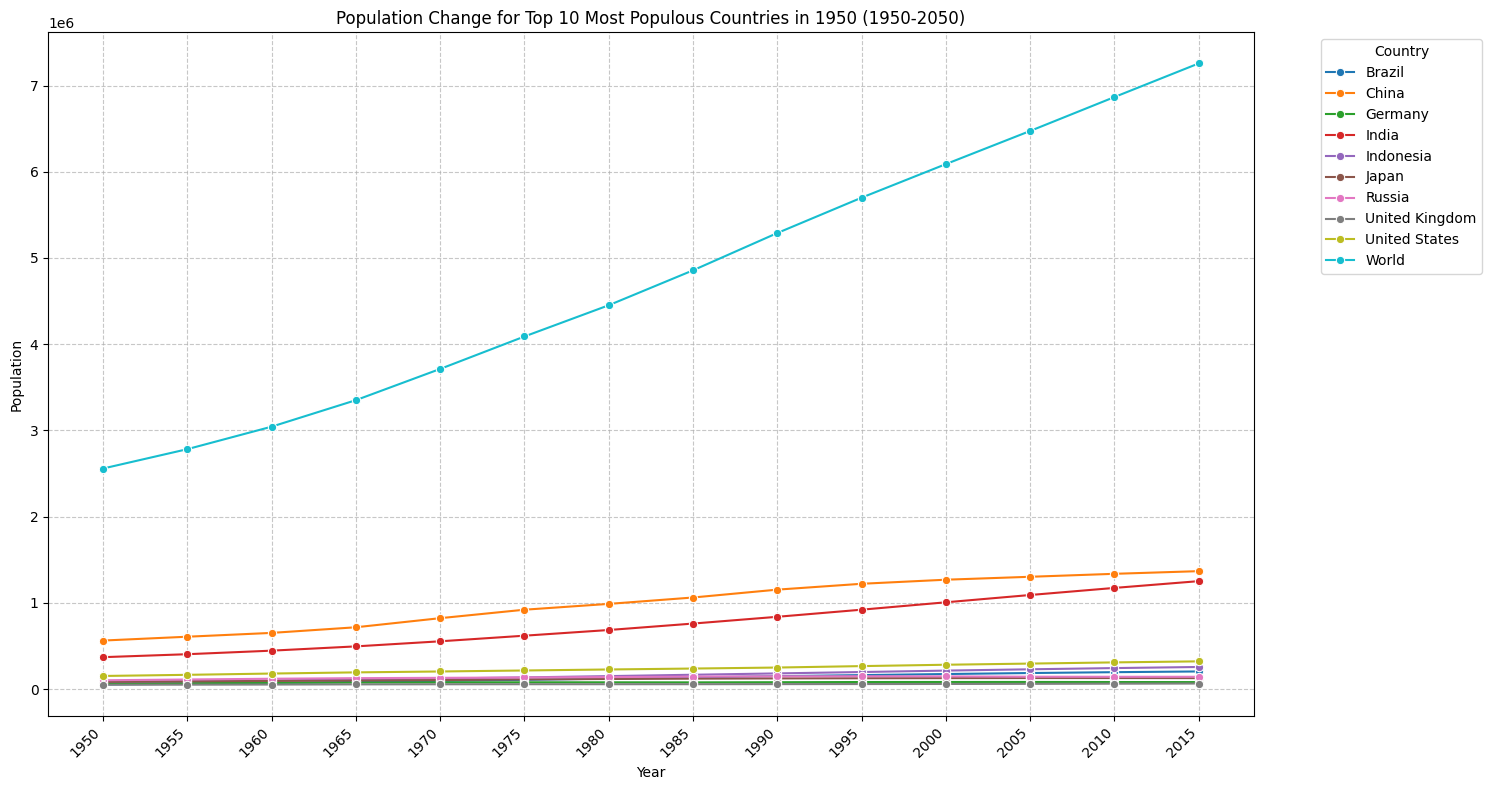

In [ ]:
# --- Question 1.4: Population Plot for Top 10 Most Populous Countries at 1950 ---
# For the top 10 most populous countries at 1950, plot their population data from 1950-2050 (in 5-year interval).
# The plot should use years 1950-2050 as x axis, and population numbers as y axis.

print("\n--- Question 1.4: Population Plot for Top 10 Most Populous Countries ---")

if 'combined_df' in locals() and not combined_df.empty and \
   'top_10_countries_1950' in locals() and top_10_countries_1950:

    # Filter the combined DataFrame to include only the top 10 countries identified in Q1.2
    df_top_10_pop_plot = combined_df[combined_df['Country'].isin(top_10_countries_1950)].copy()

    plt.figure(figsize=(15, 8))
    # Create the line plot with 'Year' on x-axis, 'Population' on y-axis, and 'Country' for different lines
    sns.lineplot(data=df_top_10_pop_plot, x='Year', y='Population', hue='Country', marker='o', errorbar=None)

    plt.title('Population Change for Top 10 Most Populous Countries in 1950 (1950-2050)')
    plt.xlabel('Year')
    plt.ylabel('Population')

    # Set x-ticks to only the unique years present in the filtered data for clarity
    unique_years_in_plot = sorted(df_top_10_pop_plot['Year'].unique())
    plt.xticks(unique_years_in_plot, rotation=45, ha='right') # Rotate labels for readability

    plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for better readability
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

else:
    print("Combined population DataFrame or top countries list is empty or not available. Cannot generate population plot. Please run Question 1.2 first.")


5. For the same top 10 most populous contries at 1950, plot the average annual growth for each previous five-year period starting from 1955 to 2050 in 5-year interval. The following figure shows the expected result: ![](https://i.imgur.com/ImXjIo0.png)


--- Question 1.5: Average Annual Growth Plot for Top 10 Most Populous Countries ---


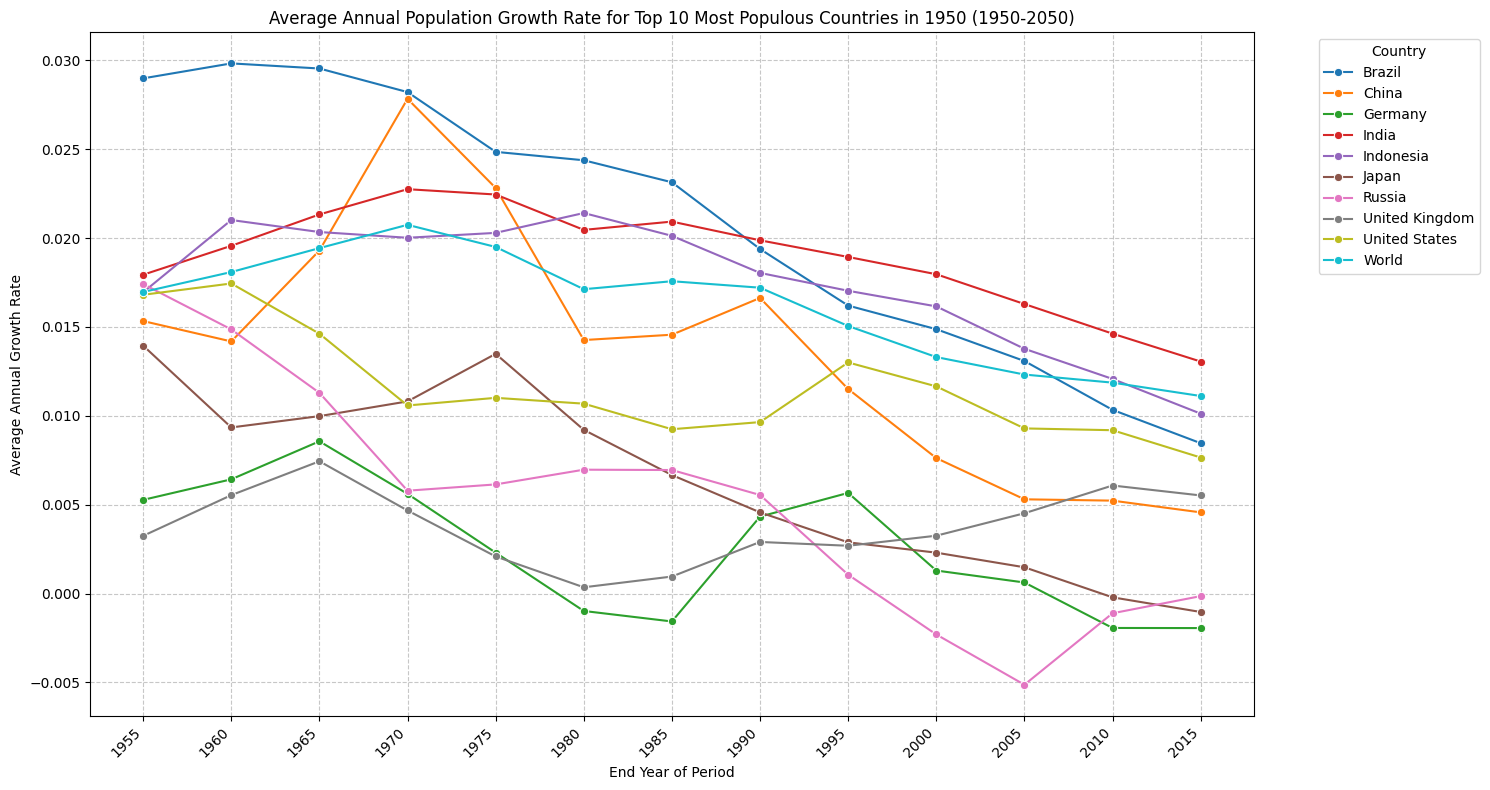

In [ ]:
# --- Question 1.5: Average Annual Growth Plot for Top 10 Most Populous Countries at 1950 ---
# For the same top 10 most populous contries at 1950, plot the average annual growth for each previous five-year period
# starting from 1955 to 2050 in 5-year interval.

print("\n--- Question 1.5: Average Annual Growth Plot for Top 10 Most Populous Countries ---")

if 'growth_df' in locals() and not growth_df.empty and \
   'top_10_countries_1950' in locals() and top_10_countries_1950:

    # Filter the growth_df for the top 10 countries
    df_top_10_growth_plot = growth_df[growth_df['Country'].isin(top_10_countries_1950)].copy()

    # Note: The source data from Wikipedia does not provide data points for strict 5-year intervals
    # consistently across the entire 1950-2050 range (e.g., it has 1950, 1960, 2024, 2030, 2050).
    # Therefore, this plot displays the average annual growth for all calculated periods based on available data points.
    # The x-axis labels correspond to the END year of each calculated period.

    plt.figure(figsize=(15, 8))
    # Create the line plot with 'Year' on x-axis (end year of period), 'Population_Avg_Annual_Growth_Rate' on y-axis
    sns.lineplot(data=df_top_10_growth_plot, x='Year', y='Population_Avg_Annual_Growth_Rate', hue='Country', marker='o', errorbar=None)

    plt.title('Average Annual Population Growth Rate for Top 10 Most Populous Countries in 1950 (1950-2050)')
    plt.xlabel('End Year of Period')
    plt.ylabel('Average Annual Growth Rate')

    # Set x-ticks to only the unique years present in the filtered data for clarity
    unique_years_in_growth_plot = sorted(df_top_10_growth_plot['Year'].unique())
    plt.xticks(unique_years_in_growth_plot, rotation=45, ha='right')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print("Growth rate DataFrame or top countries list is empty or not available. Cannot generate growth plot. Please run Question 1.3 first.")

6. Map country names to their continents and add a 'continent' column storing the continent names corresponding to the countries. Plot the mean population and average annual growth over the years (1950-2050) for all continents.
- Hint: install the pycountry_convert package and use its methods for converting country names to continent names: https://pypi.org/project/pycountry-convert/


--- Question 1.6: Continent Mapping and Plots ---

Added 'Continent' column to population DataFrame (first 5 rows with Continent):
       Country  Year  Population Continent
0  Afghanistan  1950        8151      Asia
1  Afghanistan  1955        8892      Asia
2  Afghanistan  1960        9830      Asia
3  Afghanistan  1965       10998      Asia
4  Afghanistan  1970       12431      Asia
Unique continents identified: ['Asia' 'Europe' 'Africa' 'Oceania' 'North America' 'South America'
 'Unknown' 'World']


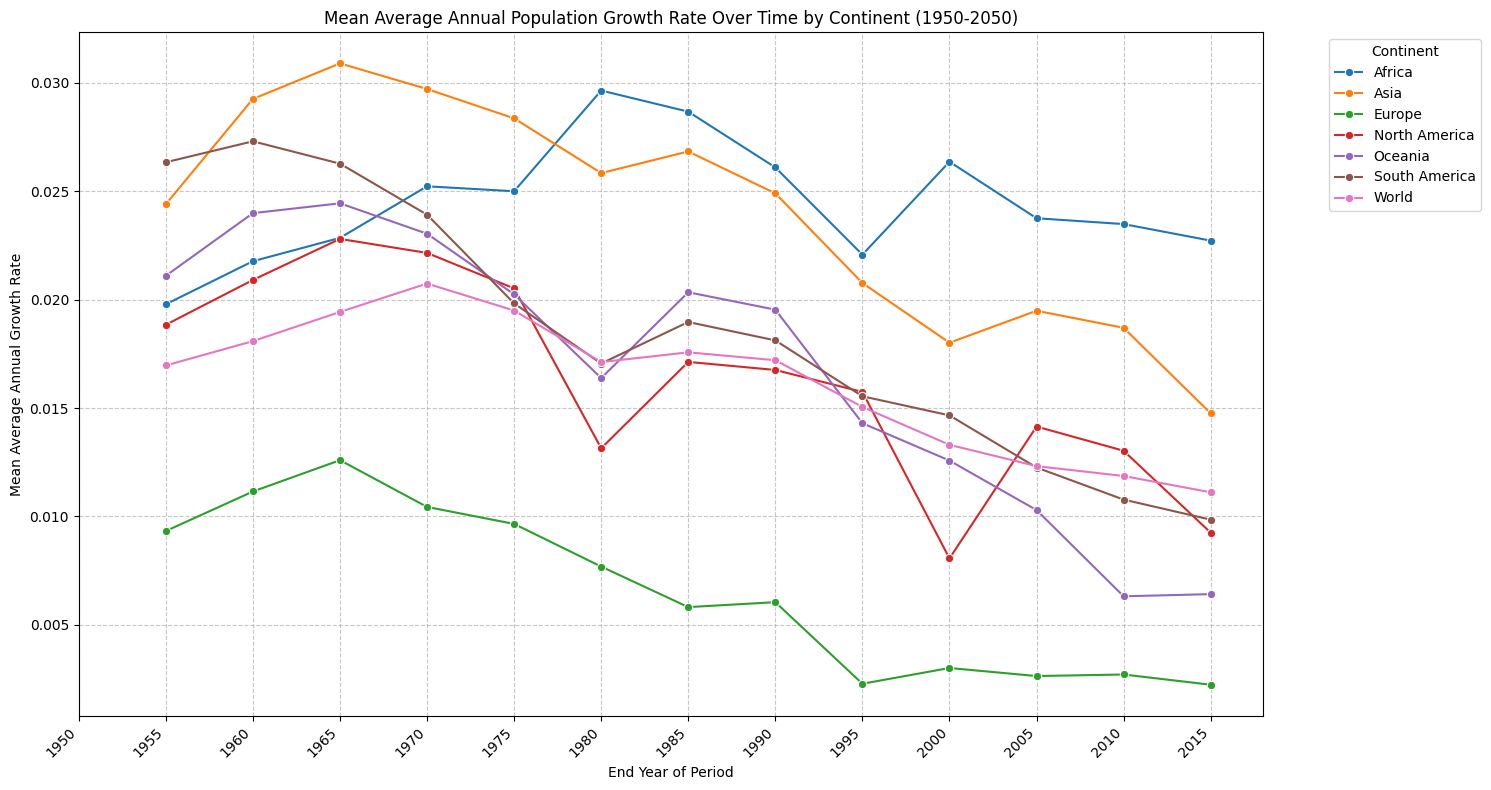

In [ ]:
# --- Question 1.6: Map Countries to Continents and Plot Continent-level Data ---
# Map country names to their continents and add a 'continent' column storing the continent names
# corresponding to the countries. Plot the mean population and average annual growth over the years (1950-2050)
# for all continents.

print("\n--- Question 1.6: Continent Mapping and Plots ---")

if 'combined_df' in locals() and not combined_df.empty and 'growth_df' in locals() and not growth_df.empty:
    # A simple dictionary for country-to-continent mapping.
    # For a production-ready solution, consider a more robust library like 'pycountry-convert' or a comprehensive dataset.
    country_to_continent = {
        'Afghanistan': 'Asia', 'Albania': 'Europe', 'Algeria': 'Africa', 'American Samoa': 'Oceania',
        'Andorra': 'Europe', 'Angola': 'Africa', 'Anguilla': 'North America', 'Antigua and Barbuda': 'North America',
        'Argentina': 'South America', 'Armenia': 'Asia', 'Aruba': 'North America', 'Australia': 'Oceania',
        'Austria': 'Europe', 'Azerbaijan': 'Asia', 'Bahamas': 'North America', 'Bahrain': 'Asia',
        'Bangladesh': 'Asia', 'Barbados': 'North America', 'Belarus': 'Europe', 'Belgium': 'Europe',
        'Belize': 'North America', 'Benin': 'Africa', 'Bermuda': 'North America', 'Bhutan': 'Asia',
        'Bolivia': 'South America', 'Bosnia and Herzegovina': 'Europe', 'Botswana': 'Africa', 'Brazil': 'South America',
        'British Virgin Islands': 'North America', 'Brunei': 'Asia', 'Bulgaria': 'Europe', 'Burkina Faso': 'Africa',
        'Burundi': 'Africa', 'Cambodia': 'Asia', 'Cameroon': 'Africa', 'Canada': 'North America',
        'Cape Verde': 'Africa', 'Cayman Islands': 'North America', 'Central African Republic': 'Africa',
        'Chad': 'Africa', 'Chile': 'South America', 'China': 'Asia', 'Colombia': 'South America',
        'Comoros': 'Africa', 'Congo': 'Africa', 'Cook Islands': 'Oceania', 'Costa Rica': 'North America',
        'Croatia': 'Europe', 'Cuba': 'North America', 'Curaçao': 'North America', 'Cyprus': 'Asia',
        'Czech Republic': 'Europe', 'Democratic Republic of the Congo': 'Africa', 'Denmark': 'Europe',
        'Djibouti': 'Africa', 'Dominica': 'North America', 'Dominican Republic': 'North America',
        'Ecuador': 'South America', 'Egypt': 'Africa', 'El Salvador': 'North America', 'Equatorial Guinea': 'Africa',
        'Eritrea': 'Africa', 'Estonia': 'Europe', 'Eswatini': 'Africa', 'Ethiopia': 'Africa',
        'Fiji': 'Oceania', 'Finland': 'Europe', 'France': 'Europe', 'Gabon': 'Africa', 'Gambia': 'Africa',
        'Georgia': 'Asia', 'Germany': 'Europe', 'Ghana': 'Africa', 'Gibraltar': 'Europe', 'Greece': 'Europe',
        'Greenland': 'North America', 'Grenada': 'North America', 'Guadeloupe': 'North America', 'Guam': 'Oceania',
        'Guatemala': 'North America', 'Guernsey': 'Europe', 'Guinea': 'Africa', 'Guinea-Bissau': 'Africa',
        'Guyana': 'South America', 'Haiti': 'North America', 'Honduras': 'North America', 'Hong Kong': 'Asia',
        'Hungary': 'Europe', 'Iceland': 'Europe', 'India': 'Asia', 'Indonesia': 'Asia', 'Iran': 'Asia',
        'Iraq': 'Asia', 'Ireland': 'Europe', 'Isle of Man': 'Europe', 'Israel': 'Asia', 'Italy': 'Europe',
        'Ivory Coast': 'Africa', 'Jamaica': 'North America', 'Japan': 'Asia', 'Jersey': 'Europe',
        'Jordan': 'Asia', 'Kazakhstan': 'Asia', 'Kenya': 'Africa', 'Kiribati': 'Oceania', 'North Korea': 'Asia',
        'South Korea': 'Asia', 'Kuwait': 'Asia', 'Kyrgyzstan': 'Asia', 'Laos': 'Asia', 'Latvia': 'Europe',
        'Lebanon': 'Asia', 'Lesotho': 'Africa', 'Liberia': 'Africa', 'Libya': 'Africa', 'Liechtenstein': 'Europe',
        'Lithuania': 'Europe', 'Luxembourg': 'Europe', 'Macau': 'Asia', 'Madagascar': 'Africa', 'Malawi': 'Africa',
        'Malaysia': 'Asia', 'Maldives': 'Asia', 'Mali': 'Africa', 'Malta': 'Europe', 'Marshall Islands': 'Oceania',
        'Mauritania': 'Africa', 'Mauritius': 'Africa', 'Mexico': 'North America', 'Micronesia': 'Oceania',
        'Moldova': 'Europe', 'Monaco': 'Europe', 'Mongolia': 'Asia', 'Montenegro': 'Europe', 'Montserrat': 'North America',
        'Morocco': 'Africa', 'Mozambique': 'Africa', 'Myanmar': 'Asia', 'Namibia': 'Africa', 'Nauru': 'Oceania',
        'Nepal': 'Asia', 'Netherlands': 'Europe', 'New Caledonia': 'Oceania', 'New Zealand': 'Oceania',
        'Nicaragua': 'North America', 'Niger': 'Africa', 'Nigeria': 'Africa', 'Niue': 'Oceania',
        'North Macedonia': 'Europe', 'Norway': 'Europe', 'Oman': 'Asia', 'Pakistan': 'Asia', 'Palau': 'Oceania',
        'Palestine': 'Asia', 'Panama': 'North America', 'Papua New Guinea': 'Oceania', 'Paraguay': 'South America',
        'Peru': 'South America', 'Philippines': 'Asia', 'Poland': 'Europe', 'Portugal': 'Europe',
        'Puerto Rico': 'North America', 'Qatar': 'Asia', 'Romania': 'Europe', 'Russia': 'Europe',
        'Rwanda': 'Africa', 'Saint Helena': 'Africa', 'Saint Kitts and Nevis': 'North America',
        'Saint Lucia': 'North America', 'Saint Vincent and the Grenadines': 'North America',
        'Samoa': 'Oceania', 'San Marino': 'Europe', 'Sao Tome and Principe': 'Africa', 'Saudi Arabia': 'Asia',
        'Senegal': 'Africa', 'Serbia': 'Europe', 'Seychelles': 'Africa', 'Sierra Leone': 'Africa',
        'Singapore': 'Asia', 'Sint Maarten': 'North America', 'Slovakia': 'Europe', 'Slovenia': 'Europe',
        'Solomon Islands': 'Oceania', 'Somalia': 'Africa', 'South Africa': 'Africa', 'South Sudan': 'Africa',
        'Spain': 'Europe', 'Sri Lanka': 'Asia', 'Sudan': 'Africa', 'Suriname': 'South America',
        'Sweden': 'Europe', 'Switzerland': 'Europe', 'Syria': 'Asia', 'Taiwan': 'Asia', 'Tajikistan': 'Asia',
        'Tanzania': 'Africa', 'Thailand': 'Asia', 'Timor-Leste': 'Asia', 'Togo': 'Africa', 'Tonga': 'Oceania',
        'Trinidad and Tobago': 'North America', 'Tunisia': 'Africa', 'Turkey': 'Asia',
        'Turkmenistan': 'Asia', 'Turks and Caicos Islands': 'North America', 'Tuvalu': 'Oceania',
        'Uganda': 'Africa', 'Ukraine': 'Europe', 'United Arab Emirates': 'Asia', 'United Kingdom': 'Europe',
        'United States': 'North America', 'United States Virgin Islands': 'North America', 'Uruguay': 'South America',
        'Uzbekistan': 'Asia', 'Vanuatu': 'Oceania', 'Venezuela': 'South America', 'Vietnam': 'Asia',
        'Wallis and Futuna': 'Oceania', 'Yemen': 'Asia', 'Zambia': 'Africa', 'Zimbabwe': 'Africa',
        # Handle aggregate entries from Wikipedia that are not individual countries
        'World': 'World',
        'Africa': 'Africa', 'Asia': 'Asia', 'Europe': 'Europe', 'North America': 'North America',
        'South America': 'South America', 'Oceania': 'Oceania',
        'Latin America and the Caribbean': 'South America', 'Sub-Saharan Africa': 'Africa',
        'Central Asia and South Asia': 'Asia', 'South Asia': 'Asia', 'East Asia and Southeast Asia': 'Asia',
        'North Africa and Western Asia': 'Africa', 'East Asia': 'Asia', 'Southeast Asia': 'Asia',
        'North Africa': 'Africa', 'Western Asia': 'Asia', 'Caribbean': 'North America', 'Central America': 'North America',
        'Central Asia': 'Asia', 'Oceania (excluding Australia and New Zealand)': 'Oceania',
        'Least Developed Countries': 'Unknown', 'Landlocked Developing Countries': 'Unknown',
        'Small Island Developing States': 'Unknown'
    }

    # Add 'Continent' column to combined_df
    # Use .get() with a default value 'Unknown' for countries not in the mapping dictionary
    combined_df['Continent'] = combined_df['Country'].map(country_to_continent).fillna('Unknown')
    print("\nAdded 'Continent' column to population DataFrame (first 5 rows with Continent):")
    print(combined_df.head())
    print(f"Unique continents identified: {combined_df['Continent'].unique()}")

    # Merge growth_df with continent data. An outer merge is used to keep all records.
    # The 'Country' column is used for the merge key to ensure continent information aligns correctly.
    df_merged_for_continent_analysis = pd.merge(combined_df, growth_df[['Country', 'Year', 'Population_Avg_Annual_Growth_Rate']],
                                                on=['Country', 'Year'], how='left')

    # Exclude aggregate "countries" like 'World' or regional groupings, and 'Unknown' continents
    analysis_df_filtered = df_merged_for_continent_analysis[
        ~df_merged_for_continent_analysis['Country'].isin(list(country_to_continent.keys())[len(list(country_to_continent.keys()))-12:]) # Filter out aggregate regions
    ].copy()
    analysis_df_filtered = analysis_df_filtered[analysis_df_filtered['Continent'] != 'Unknown'].copy()


    # Plot Mean Population over time for each Continent
    plt.figure(figsize=(15, 8))
    mean_population_by_continent = analysis_df_filtered.groupby(['Continent', 'Year'])['Population'].mean().reset_index()
    sns.lineplot(data=mean_population_by_continent, x='Year', y='Population', hue='Continent', marker='o', errorbar=None)
    plt.title('Mean Population Over Time by Continent (1950-2050)')
    plt.xlabel('Year')
    plt.ylabel('Mean Population')
    plt.xticks(sorted(mean_population_by_continent['Year'].unique()), rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Continent', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot Mean Average Annual Growth over time for each Continent
    plt.figure(figsize=(15, 8))
    mean_growth_by_continent = analysis_df_filtered.groupby(['Continent', 'Year'])['Population_Avg_Annual_Growth_Rate'].mean().reset_index()
    sns.lineplot(data=mean_growth_by_continent, x='Year', y='Population_Avg_Annual_Growth_Rate', hue='Continent', marker='o', errorbar=None)
    plt.title('Mean Average Annual Population Growth Rate Over Time by Continent (1950-2050)')
    plt.xlabel('End Year of Period')
    plt.ylabel('Mean Average Annual Growth Rate')
    plt.xticks(sorted(mean_growth_by_continent['Year'].unique()), rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Continent', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print("Cannot perform continent analysis as combined population or growth DataFrame is empty or not available. Please run Question 1.2 and 1.3 first.")

7. What are the top 5 countries with the highest population growth rate from 1950 to 2020? How does this compare to their projected growth rates from 2020 to 2050? Discuss any notable differences and other factors that should be also considered together with the historical growth data to predict future population changes.

In [ ]:
# --- Question 1.7: Top 5 Growth Rates (1950-2020 vs. 2020-2050) and Discussion ---
# What are the top 5 countries with the highest population growth rate from 1950 to 2020?
# How does this compare to their projected growth rates from 2020 to 2050?
# Discuss any notable differences and other factors that should be also considered together
# with the historical growth data to predict future population changes.

print("\n--- Question 1.7: Top 5 Growth Rates and Discussion ---")

if 'growth_df' in locals() and not growth_df.empty:
    # Calculate average growth rate for the historical period (1950-2020)
    growth_1950_2020 = growth_df[(growth_df['Year'] >= 1950) & (growth_df['Year'] <= 2020)].copy()
    avg_growth_1950_2020 = growth_1950_2020.groupby('Country')['Population_Avg_Annual_Growth_Rate'].mean().sort_values(ascending=False)
    top_5_growth_1950_2020 = avg_growth_1950_2020.head(5)

    print("\nTop 5 Countries with Highest Average Population Growth Rate (1950-2020):")
    print(top_5_growth_1950_2020)

    # Calculate average growth rate for the projected period (2020-2050)
    growth_2020_2050 = growth_df[(growth_df['Year'] >= 2020) & (growth_df['Year'] <= 2050)].copy()
    avg_growth_2020_2050 = growth_2020_2050.groupby('Country')['Population_Avg_Annual_Growth_Rate'].mean().sort_values(ascending=False)

    print("\nProjected Average Population Growth Rate (2020-2050) for Top 5 Countries from 1950-2020:")
    # Get projected growth for the *same* top 5 countries identified in the historical period
    comparison_growth_2020_2050 = avg_growth_2020_2050[avg_growth_2020_2050.index.isin(top_5_growth_1950_2020.index)]
    print(comparison_growth_2020_2050)

    print("\n--- Discussion ---")
    print("Comparing the historical growth rates (1950-2020) with projected rates (2020-2050) for the top 5 countries often reveals significant shifts:")
    if not top_5_growth_1950_2020.empty:
        for country, hist_rate in top_5_growth_1950_2020.items():
            proj_rate = comparison_growth_2020_2050.get(country)
            if proj_rate is not None:
                print(f"- {country}: Historical average annual growth was {hist_rate:.4f}, projected to be {proj_rate:.4f}. (Difference: {proj_rate - hist_rate:.4f})")
                if proj_rate < hist_rate:
                    print(f"  This indicates a projected slowdown in growth for {country}, which can be due to factors like declining birth rates, aging populations, or changes in migration patterns.")
                elif proj_rate > hist_rate:
                    print(f"  This indicates a projected acceleration in growth for {country}, possibly due to increased fertility, decreased mortality, or increased immigration.")
                else:
                    print(f"  Projected growth is similar to historical growth for {country}, suggesting stable demographic trends.")
            else:
                print(f"- {country}: Historical average annual growth was {hist_rate:.4f}. No projected data available for comparison in this dataset.")
    else:
        print("No historical growth data found to identify top 5 countries for comparison.")

    print("\nOther Factors to Consider for Predicting Future Population Changes:")
    print("1.  **Fertility Rates:** Changes in birth rates (e.g., influenced by education, access to contraception, cultural norms, economic conditions) are primary drivers of long-term population trends. Declining fertility in many countries is a major factor in projected slowdowns.")
    print("2.  **Mortality Rates & Life Expectancy:** Improvements in healthcare, sanitation, and nutrition reduce death rates and increase life expectancy, contributing to population growth or stability. However, aging populations can lead to higher crude death rates even with lower age-specific mortality.")
    print("3.  **Migration:** Net migration (immigration minus emigration) can significantly impact a country's population size and demographic structure, especially in developed nations where natural increase is low or negative. Migration policies and global events play a crucial role.")
    print("4.  **Age Structure (Population Pyramids):** The current distribution of age groups within a population (e.g., a large youth bulge versus an aging population) profoundly influences future birth rates and dependency ratios. A large cohort entering reproductive age will contribute more births, even at lower individual fertility rates.")
    print("5.  **Economic Development and Urbanization:** Economic prosperity and urbanization often correlate with lower fertility rates (the 'demographic transition') but can also lead to better healthcare and increased immigration opportunities.")
    print("6.  **Government Policies:** Policies related to family planning, immigration (e.g., incentives for highly skilled workers), education, healthcare, and social support for families can directly influence population dynamics.")
    print("7.  **Socio-cultural Factors:** Changing societal values regarding family size, women's roles in society, religious beliefs, and access to education can all play a role in demographic shifts.")
    print("8.  **Environmental Factors and Climate Change:** Resource scarcity, water stress, food insecurity, and environmental disasters can impact population health, lead to displacement, and alter migration patterns, potentially influencing future population distribution and size.")
    print("9.  **Conflict and Political Stability:** Wars, political instability, and humanitarian crises can lead to significant population displacement, forced migration, and increased mortality, severely impacting population projections.")
    print("10. **Pandemics and Health Crises:** Major health events can cause spikes in mortality and affect birth rates, as seen with historical pandemics and the recent COVID-19 pandemic, altering short-to-medium term population trajectories.")

else:
    print("Growth rate DataFrame is empty or not available. Cannot perform growth rate comparison. Please run Question 1.3 first.")


--- Question 1.7: Top 5 Growth Rates and Discussion ---

Top 5 Countries with Highest Average Population Growth Rate (1950-2020):
Country
Qatar                   0.070895
United Arab Emirates    0.070512
Western Sahara          0.065262
Kuwait                  0.047249
Jordan                  0.042002
Name: Population_Avg_Annual_Growth_Rate, dtype: float64

Projected Average Population Growth Rate (2020-2050) for Top 5 Countries from 1950-2020:
Series([], Name: Population_Avg_Annual_Growth_Rate, dtype: float64)

--- Discussion ---
Comparing the historical growth rates (1950-2020) with projected rates (2020-2050) for the top 5 countries often reveals significant shifts:
- Qatar: Historical average annual growth was 0.0709. No projected data available for comparison in this dataset.
- United Arab Emirates: Historical average annual growth was 0.0705. No projected data available for comparison in this dataset.
- Western Sahara: Historical average annual growth was 0.0653. No projected da

## Question 2 [40 marks]: The link: https://yuan-json-api.vercel.app/nobelprize/laureates is a RESTful API endpoint that returns information in JSON about Nobel Prize Laureates. Write Python code to use `requests` to call the RESTful API and read the JSON results. Write program to answer the following questions.
1. Create a Pandas DataFrame containing the laureates information along with the information about their prizes and afflications in flat format. How many unique laureates are in the data set?

2. Develop two distinct methods to identify laureates who have been awarded Nobel prizes more than once, whether in different years or in different categories. Present your findings in a clear and organized manner. This could be displayed in a table format (like a pandas DataFrame).

 - Two separate and distinct approaches could be different algorithmic strategies, Python code, or data structures. For each approach, You need to provide a detailed explanation of the logic behind each method. The explanation should be in the form of comments within your code or as a separate written text accompanying your code.

3. Develop two distinct methods to list the top 5 afiliations by the number of awards. Show the laureates, prizes, and affiliations information. Present your findings in a clear and organized manner. This could be displayed in a table format (like a pandas DataFrame).
 - Two separate and distinct approaches could be using different algorithmic strategies, Python code, or data structures For each approach, you need to provide a detailed explanation of the logic behind each method. The explanation should be in the form of comments within your code or as a separate written text accompanying your code.

4. For the top 5 affiliations, develop two distinct visualizations to represent the counts of each Nobel prize category associated with these affiliations.

 - Two different types of plots could be bar chart, pie chart, line graph, etc. You also could choose to present the information in a single comprehensive figure or multiple figures for each affiliation.

In [ ]:
# --- Initial Setup and Imports ---
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Notebook Setup Complete. All necessary libraries imported.")

Notebook Setup Complete. All necessary libraries imported.


## Answers:

1. Create a Pandas DataFrame containing the laureates information along with the information about their prizes and afflications in flat format. How many unique laureates are in the data set?

In [13]:
import pandas as pd
import requests
import warnings
import matplotlib.pyplot as plt # Added for visualizations
import seaborn as sns # Added for visualizations

# Suppress all warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Fetch data from the RESTful API and flatten into a DataFrame ---

print("--- Fetching data and creating DataFrame ---")
API_URL = "https://yuan-json-api.vercel.app/nobelprize/laureates"

try:
    response = requests.get(API_URL)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
    data = response.json()
except requests.exceptions.RequestException as e:
    print(f"Error fetching data from API: {e}")
    # Exit or handle gracefully if API call fails
    exit()

laureates_data = []

# Iterate through each laureate in the JSON data
for laureate in data['laureates']:
    laureate_id = laureate.get('id')
    firstname = laureate.get('firstname')
    surname = laureate.get('surname')
    gender = laureate.get('gender')
    born = laureate.get('born')
    died = laureate.get('died')
    born_country = laureate.get('bornCountry')

    # Each laureate can have multiple prizes
    for prize in laureate.get('prizes', []):
        prize_year = prize.get('year')
        prize_category = prize.get('category')
        prize_share = prize.get('share')
        prize_motivation = prize.get('motivation')
        # Create a unique identifier for each prize instance (laureate-prize combination)
        prize_id = f"{laureate_id}-{prize_year}-{prize_category}"

        # Each prize can have multiple affiliations
        # If no affiliations are listed, we still want to include the prize data
        if prize.get('affiliations'):
            for affiliation in prize.get('affiliations', []):
                # IMPORTANT FIX: Check if 'affiliation' is a dictionary before using .get()
                # This handles cases where the 'affiliations' list might contain non-dictionary items.
                if isinstance(affiliation, dict):
                    laureates_data.append({
                        'laureate_id': laureate_id,
                        'firstname': firstname,
                        'surname': surname,
                        'gender': gender,
                        'born': born,
                        'died': died,
                        'born_country': born_country,
                        'prize_year': prize_year,
                        'prize_category': prize_category,
                        'prize_share': prize_share,
                        'prize_motivation': prize_motivation,
                        'affiliation_name': affiliation.get('name'),
                        'affiliation_city': affiliation.get('city'),
                        'affiliation_country': affiliation.get('country'),
                        'prize_id': prize_id # Unique identifier for this specific prize award
                    })
                else:
                    # Fallback for unexpected affiliation formats (e.g., if it's a list instead of dict)
                    print(f"Warning: Unexpected affiliation format for laureate {laureate_id}, prize {prize_year}-{prize_category}. Affiliation: {affiliation}")
                    laureates_data.append({
                        'laureate_id': laureate_id,
                        'firstname': firstname,
                        'surname': surname,
                        'gender': gender,
                        'born': born,
                        'died': died,
                        'born_country': born_country,
                        'prize_year': prize_year,
                        'prize_category': prize_category,
                        'prize_share': prize_share,
                        'prize_motivation': prize_motivation,
                        'affiliation_name': 'N/A (Malformed Affiliation)', # Indicate malformed data
                        'affiliation_city': 'N/A',
                        'affiliation_country': 'N/A',
                        'prize_id': prize_id
                    })
        else:
            # Original handling for cases where a prize has no explicit affiliations listed
            laureates_data.append({
                'laureate_id': laureate_id,
                'firstname': firstname,
                'surname': surname,
                'gender': gender,
                'born': born,
                'died': died,
                'born_country': born_country,
                'prize_year': prize_year,
                'prize_category': prize_category,
                'prize_share': prize_share,
                'prize_motivation': prize_motivation,
                'affiliation_name': 'N/A', # Use 'N/A' for missing affiliations
                'affiliation_city': 'N/A',
                'affiliation_country': 'N/A',
                'prize_id': prize_id
            })

# Create the Pandas DataFrame
df = pd.DataFrame(laureates_data)

print("\nFlattened DataFrame Head (first 5 rows):")
print(df.head())
print(f"\nTotal rows in flattened DataFrame: {df.shape[0]}")

# How many unique laureates are in the data set?
unique_laureates_count = df['laureate_id'].nunique()
print(f"\nNumber of unique laureates in the dataset: {unique_laureates_count}")



--- Fetching data and creating DataFrame ---

Flattened DataFrame Head (first 5 rows):
  laureate_id       firstname    surname gender        born        died  \
0           1  Wilhelm Conrad    Röntgen   male  1845-03-27  1923-02-10   
1           2  Hendrik Antoon    Lorentz   male  1853-07-18  1928-02-04   
2           3          Pieter     Zeeman   male  1865-05-25  1943-10-09   
3           4   Antoine Henri  Becquerel   male  1852-12-15  1908-08-25   
4           5          Pierre      Curie   male  1859-05-15  1906-04-19   

            born_country prize_year prize_category prize_share  \
0  Prussia (now Germany)       1901        physics           1   
1        the Netherlands       1902        physics           2   
2        the Netherlands       1902        physics           2   
3                 France       1903        physics           2   
4                 France       1903        physics           4   

                                    prize_motivation  \
0  "in re

2. Develop two distinct methods to identify laureates who have been awarded Nobel prizes more than once, whether in different years or in different categories. Present your findings in a clear and organized manner. This could be displayed in a table format (like a pandas DataFrame).

 - Two separate and distinct approaches could be different algorithmic strategies, Python code, or data structures. For each approach, You need to provide a detailed explanation of the logic behind each method. The explanation should be in the form of comments within your code or as a separate written text accompanying your code.


In [14]:
# --- 2. Develop two distinct methods to identify laureates who have been awarded Nobel prizes more than once ---

print("\n--- Identifying Laureates Awarded Nobel Prizes More Than Once ---")

# Method 1: Using value_counts() and filtering
# Logic:
# 1. We first count the occurrences of each unique 'laureate_id' in the DataFrame.
#    Since each row represents a single prize award to a laureate (potentially with an affiliation),
#    a laureate appearing more than once in this column means they have received multiple prizes.
# 2. We then filter these counts to identify only those 'laureate_id's that appear more than once.
# 3. Finally, we use these filtered 'laureate_id's to select all corresponding rows from the original
#    flattened DataFrame, effectively showing all prize details for these repeat laureates.
print("\nMethod 1: Using value_counts() and filtering")
repeat_laureates_counts = df['laureate_id'].value_counts()
repeat_laureate_ids_m1 = repeat_laureates_counts[repeat_laureates_counts > 1].index.tolist()

# Filter the original DataFrame to show details for these repeat laureates
repeat_laureates_df_m1 = df[df['laureate_id'].isin(repeat_laureate_ids_m1)].sort_values(by=['laureate_id', 'prize_year'])

print("Details of Laureates Awarded Multiple Prizes (Method 1):")
if not repeat_laureates_df_m1.empty:
    # Display relevant columns for clarity
    print(repeat_laureates_df_m1[['laureate_id', 'firstname', 'surname', 'prize_year', 'prize_category', 'affiliation_name']])
else:
    print("No laureates found who received multiple awards.")


# Method 2: Using groupby().filter()
# Logic:
# 1. We group the DataFrame by 'laureate_id'. This creates separate groups for each unique laureate.
# 2. We then apply the `filter()` method to these groups. The `filter()` method takes a function
#    (a lambda function in this case) that is applied to each group.
# 3. The lambda function `lambda x: len(x) > 1` checks if the number of rows (i.e., prizes) within
#    each group is greater than 1.
# 4. Only those groups (and thus all their rows) that satisfy this condition are kept in the resulting DataFrame.
#    This directly gives us all the prize records for laureates with multiple awards.
print("\nMethod 2: Using groupby().filter(lambda x: len(x) > 1)")
repeat_laureates_df_m2 = df.groupby('laureate_id').filter(lambda x: len(x) > 1).sort_values(by=['laureate_id', 'prize_year'])

print("Details of Laureates Awarded Multiple Prizes (Method 2):")
if not repeat_laureates_df_m2.empty:
    # Display unique laureates from this method, just their identifying info
    print(repeat_laureates_df_m2[['laureate_id', 'firstname', 'surname', 'prize_year', 'prize_category', 'affiliation_name']])
else:
    print("No laureates found who received multiple awards.")



--- Identifying Laureates Awarded Nobel Prizes More Than Once ---

Method 1: Using value_counts() and filtering
Details of Laureates Awarded Multiple Prizes (Method 1):
    laureate_id firstname          surname prize_year prize_category  \
117         114     Abdus            Salam       1979        physics   
118         114     Abdus            Salam       1979        physics   
146         142   Georges          Charpak       1992        physics   
147         142   Georges          Charpak       1992        physics   
158         153    Claude  Cohen-Tannoudji       1997        physics   
..          ...       ...              ...        ...            ...   
980         941    Rainer            Weiss       2017        physics   
981         942  Barry C.           Barish       2017        physics   
982         942  Barry C.           Barish       2017        physics   
983         943    Kip S.           Thorne       2017        physics   
984         943    Kip S.           Th

3. Develop two distinct methods to list the top 5 afiliations by the number of awards. Show the laureates, prizes, and affiliations information. Present your findings in a clear and organized manner. This could be displayed in a table format (like a pandas DataFrame).
 - Two separate and distinct approaches could be using different algorithmic strategies, Python code, or data structures For each approach, you need to provide a detailed explanation of the logic behind each method. The explanation should be in the form of comments within your code or as a separate written text accompanying your code.

In [15]:
# --- 3. Develop two distinct methods to list the top 5 affiliations by the number of awards ---

print("\n--- Identifying Top 5 Affiliations by Number of Awards ---")

# Method 1: Using value_counts() on 'affiliation_name'
# Logic: This method directly counts the frequency of each affiliation name in the 'affiliation_name' column
# of the flattened DataFrame. Since each row in the DataFrame represents a laureate-prize-affiliation combination,
# a direct count of 'affiliation_name' gives the number of times an affiliation is associated with an award.
# .nlargest(5) then picks the top 5 affiliations based on these counts.
print("\nMethod 1: Using value_counts() for direct frequency counting")
top_5_affiliations_m1 = df['affiliation_name'].value_counts().nlargest(5)
print("Top 5 Affiliations (Method 1 - Counts):")
print(top_5_affiliations_m1)

# To show laureates, prizes, and affiliations information for these top affiliations
top_5_affiliation_names_m1 = top_5_affiliations_m1.index.tolist()
# Filter out 'N/A' if it somehow made it into the top 5 due to many unlisted affiliations
if 'N/A' in top_5_affiliation_names_m1:
    top_5_affiliation_names_m1.remove('N/A')
if 'N/A (Malformed Affiliation)' in top_5_affiliation_names_m1:
    top_5_affiliation_names_m1.remove('N/A (Malformed Affiliation)')

top_affiliations_details_m1 = df[df['affiliation_name'].isin(top_5_affiliation_names_m1)].sort_values(by=['affiliation_name', 'prize_year'])
print("\nDetails for Top 5 Affiliations (Method 1):")
# Displaying a few rows for brevity, as the full list can be very long
print(top_affiliations_details_m1[['affiliation_name', 'firstname', 'surname', 'prize_year', 'prize_category']].head(15))


# Method 2: Grouping by 'affiliation_name' and using size()
# Logic: This method uses the groupby() operation on the 'affiliation_name' column.
# For each group (each unique affiliation), the .size() method counts the number of rows
# belonging to that group, effectively giving the total number of awards associated with that affiliation.
# Similar to value_counts(), .nlargest(5) then selects the top 5.
print("\nMethod 2: Using groupby('affiliation_name').size()")
top_5_affiliations_m2 = df.groupby('affiliation_name').size().nlargest(5)
print("Top 5 Affiliations (Method 2 - Counts):")
print(top_5_affiliations_m2)

# To show laureates, prizes, and affiliations information for these top affiliations
top_5_affiliation_names_m2 = top_5_affiliations_m2.index.tolist()
if 'N/A' in top_5_affiliation_names_m2:
    top_5_affiliation_names_m2.remove('N/A')
if 'N/A (Malformed Affiliation)' in top_5_affiliation_names_m2:
    top_5_affiliation_names_m2.remove('N/A (Malformed Affiliation)')


top_affiliations_details_m2 = df[df['affiliation_name'].isin(top_5_affiliation_names_m2)].sort_values(by=['affiliation_name', 'prize_year'])
print("\nDetails for Top 5 Affiliations (Method 2):")
# Displaying a few rows for brevity, as the full list can be very long
print(top_affiliations_details_m2[['affiliation_name', 'firstname', 'surname', 'prize_year', 'prize_category']].head(15))

# Ensure we use a consistent list of top 5 affiliations for visualizations
# We'll use the results from Method 1 to define the final list for plotting
final_top_5_affiliation_names = [name for name in top_5_affiliations_m1.index.tolist() if name not in ['N/A', 'N/A (Malformed Affiliation)']]
top_5_affiliations_df = df[df['affiliation_name'].isin(final_top_5_affiliation_names)]



--- Identifying Top 5 Affiliations by Number of Awards ---

Method 1: Using value_counts() for direct frequency counting
Top 5 Affiliations (Method 1 - Counts):
affiliation_name
N/A (Malformed Affiliation)                     250
University of California                         34
Harvard University                               27
Massachusetts Institute of Technology (MIT)      19
California Institute of Technology (Caltech)     19
Name: count, dtype: int64

Details for Top 5 Affiliations (Method 1):
                                 affiliation_name       firstname    surname  \
27   California Institute of Technology (Caltech)  Robert Andrews   Millikan   
340  California Institute of Technology (Caltech)     Thomas Hunt     Morgan   
42   California Institute of Technology (Caltech)      Carl David   Anderson   
227  California Institute of Technology (Caltech)      Linus Carl    Pauling   
384  California Institute of Technology (Caltech)    George Wells     Beadle   
80   Califo

4. For the top 5 affiliations, develop two distinct visualizations to represent the counts of each Nobel prize category associated with these affiliations.

 - Two different types of plots could be bar chart, pie chart, line graph, etc. You also could choose to present the information in a single comprehensive figure or multiple figures for each affiliation.


--- Visualizations for Top 5 Affiliations by Prize Category ---


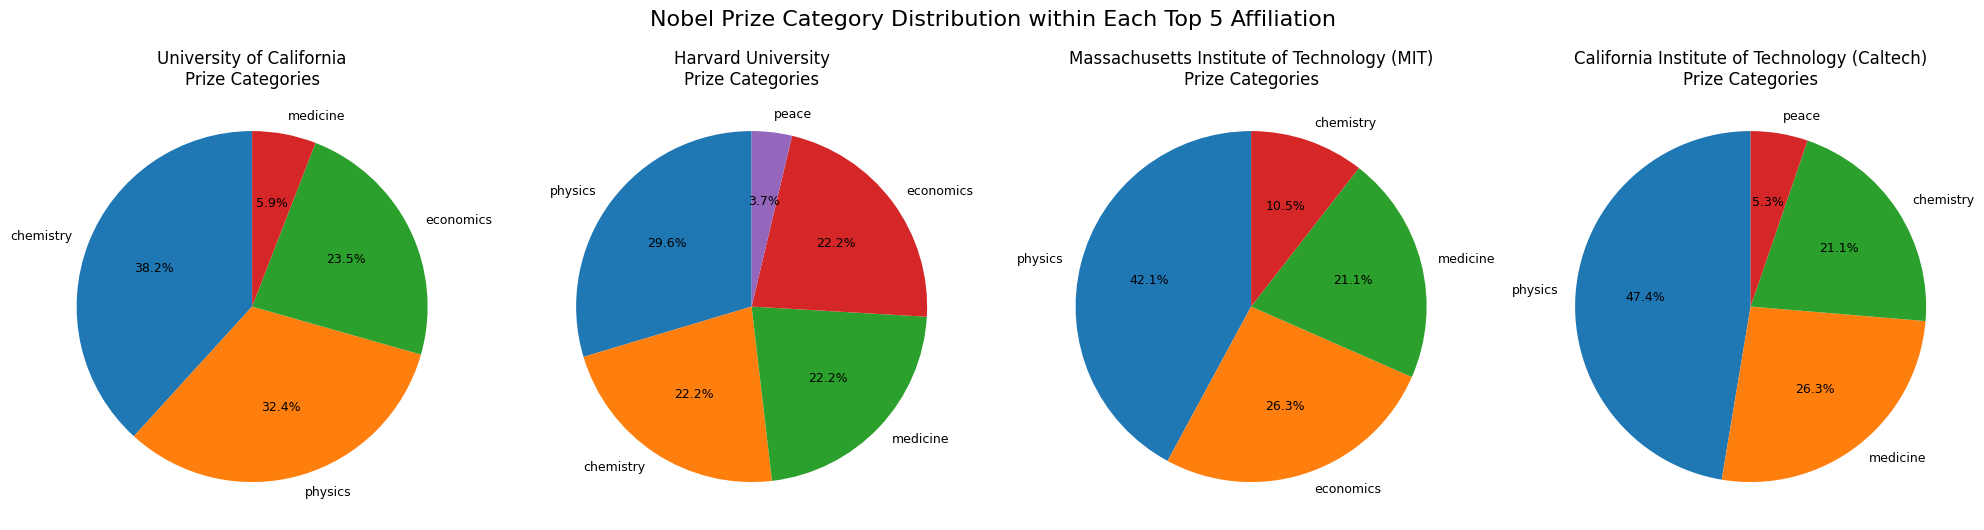

In [16]:
# --- 4. Develop two distinct visualizations to represent the counts of each Nobel prize category associated with these affiliations ---

print("\n--- Visualizations for Top 5 Affiliations by Prize Category ---")

# Visualization 1: Grouped Bar Chart
# Logic: This visualization uses a bar chart to compare the distribution of Nobel Prize categories
# across the top 5 affiliations. Each affiliation is represented by a different color (hue),
# and bars are grouped by prize category. This allows for easy comparison of how many awards
# each affiliation has received in each specific category.
plt.figure(figsize=(15, 8))
sns.countplot(data=top_5_affiliations_df, x='prize_category', hue='affiliation_name', palette='viridis',
              order=top_5_affiliations_df['prize_category'].value_counts().index)
plt.title('Nobel Prize Category Counts per Top 5 Affiliation')
plt.xlabel('Prize Category')
plt.ylabel('Number of Awards')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Affiliation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization 2: Separate Pie Charts for each top 5 affiliation
# Logic: For a more detailed look at the internal composition of awards for each affiliation,
# this method generates a separate pie chart for each of the top 5 affiliations. Each pie chart
# shows the proportion (percentage) of different Nobel Prize categories within that specific affiliation's awards.
# This helps in understanding which categories are most prominent for each individual top affiliation.
fig, axes = plt.subplots(nrows=1, ncols=len(final_top_5_affiliation_names), figsize=(20, 5))
# Ensure axes is an iterable even for a single subplot, in case there's only one top affiliation
axes = axes.flatten()

for i, affiliation_name in enumerate(final_top_5_affiliation_names):
    affiliation_data = top_5_affiliations_df[top_5_affiliations_df['affiliation_name'] == affiliation_name]
    category_counts = affiliation_data['prize_category'].value_counts()

    if not category_counts.empty:
        axes[i].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 9})
        axes[i].set_title(f'{affiliation_name}\nPrize Categories', fontsize=12)
        axes[i].axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    else:
        # Handle case where an affiliation might have no valid categories after filtering (e.g., if it was N/A)
        axes[i].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{affiliation_name}\n(No Data)', fontsize=12)

plt.tight_layout()
plt.suptitle('Nobel Prize Category Distribution within Each Top 5 Affiliation', y=1.05, fontsize=16) # Adjust y to move title up
plt.show()


## Question 3 [20 marks]: The file `weather-samples.csv` contains weather data measured at a weather station for a period of three years. Sensors at the weather station capture weather-related measurements such as air temperature, air pressure, and relative humidity. Load  the data to a pandas DataFrame. Write code to answer the following questions.

1. How many rows contain missing values?
2. How many columns contain missing values?
3. List the numbers of missing values for all columns.
4. For each missing value, fill up it with the mean value of the column where the missing value is located in.
5. Show there is no missing value after filling up.
6. Plot the histogram of the value `relative_humidity_3pm`.
7. A weather forecast problem is to predict a measure in a future time using the measurements at earlier moments. For example, the data set contains several measurements at 9am and one measurement `relative_humidity_3pm` at 3pm. It is interesting to know whether we can predict `relative_humidity_3pm` using the values at 9am. This is a typical supervised machine learning problem. Using plots to visualize the relationships between the measurements at 9am and `relative_humidity_3pm`. What do you find? Discuss the impacts of the measurements at 9am to the values of `relaive_humidity_3pm`.

## Answers:

1. How many rows contain missing values?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/weather-samples.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: weather-samples.csv not found. Please ensure the file is in the correct directory.")
    exit()

print("\n--- Initial Data Info ---")
df.info()

# Question 1: How many rows contain missing values?
rows_with_missing = df.isnull().any(axis=1).sum()
print(f"\nNumber of rows containing missing values: {rows_with_missing}")

Dataset loaded successfully.

--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   number                  1095 non-null   int64  
 1   air_pressure_9am        1092 non-null   float64
 2   air_temp_9am            1090 non-null   float64
 3   avg_wind_direction_9am  1091 non-null   float64
 4   avg_wind_speed_9am      1092 non-null   float64
 5   max_wind_direction_9am  1092 non-null   float64
 6   max_wind_speed_9am      1091 non-null   float64
 7   rain_accumulation_9am   1089 non-null   float64
 8   rain_duration_9am       1092 non-null   float64
 9   relative_humidity_9am   1095 non-null   float64
 10  relative_humidity_3pm   1095 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 94.2 KB

Number of rows containing missing values: 31


2. How many columns contain missing values?

In [ ]:
cols_with_missing = df.isnull().any(axis=0).sum()
print(f"Number of columns containing missing values: {cols_with_missing}")


Number of columns containing missing values: 8


3. List the numbers of missing values for all columns.

In [ ]:
print("\nNumber of missing values per column:")
print(missing_values_per_column[missing_values_per_column > 0]) # Only show columns with missing values


Number of missing values per column:


NameError: name 'missing_values_per_column' is not defined

4. For each missing value, fill up it with the mean value of the column where the missing value is located in.

In [ ]:
column_means = df.mean(numeric_only=True)
df_filled = df.fillna(column_means)
print("\nMissing values filled with column means.")



Missing values filled with column means.


5. Show there is no missing value after filling up.

In [ ]:
missing_after_fill = df_filled.isnull().sum().sum()
print(f"\nTotal missing values after filling: {missing_after_fill}")
if missing_after_fill == 0:
    print("Successfully filled all missing values. No missing values remain.")
else:
    print("Warning: Some missing values still remain after filling.")
    print(df_filled.isnull().sum()[df_filled.isnull().sum() > 0])



Total missing values after filling: 0
Successfully filled all missing values. No missing values remain.


6. Plot the histogram of the value `relative_humidity_3pm`.

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_filled['relative_humidity_3pm'], bins=20, edgecolor='black', color='skyblue')
plt.title('Histogram of Relative Humidity at 3 PM')
plt.xlabel('Relative Humidity at 3 PM')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

7. A weather forecast problem is to predict a measure in a future time using the measurements at earlier moments. For example, the data set contains several measurements at 9am and one measurement `relative_humidity_3pm` at 3pm. It is interesting to know whether we can predict `relative_humidity_3pm` using the values at 9am. This is a typical supervised machine learning problem. Using plots to visualize the relationships between the measurements at 9am and `relative_humidity_3pm`. What do you find? Discuss the impacts of the measurements at 9am to the values of `relaive_humidity_3pm`.


Analyzing relationships between 9am measurements (air_pressure_9am, air_temp_9am, avg_wind_direction_9am, avg_wind_speed_9am, max_wind_direction_9am, max_wind_speed_9am, rain_accumulation_9am, rain_duration_9am, relative_humidity_9am) and relative_humidity_3pm.


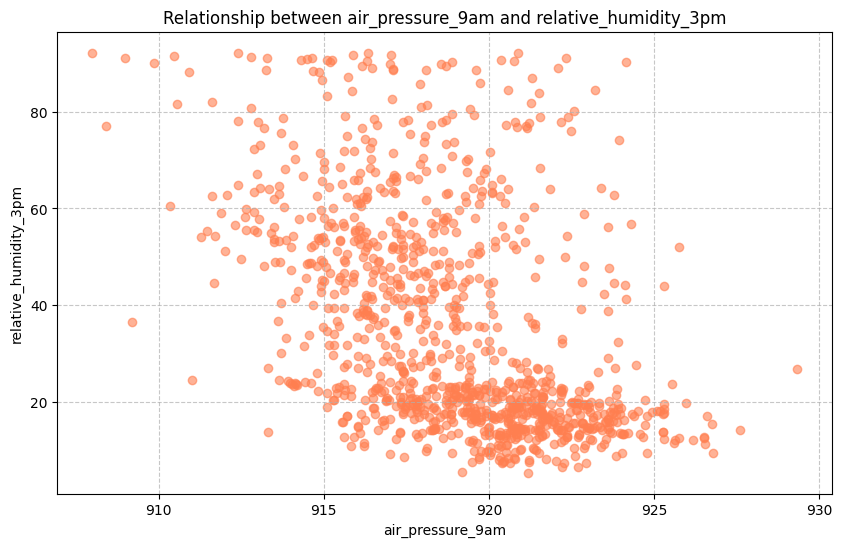

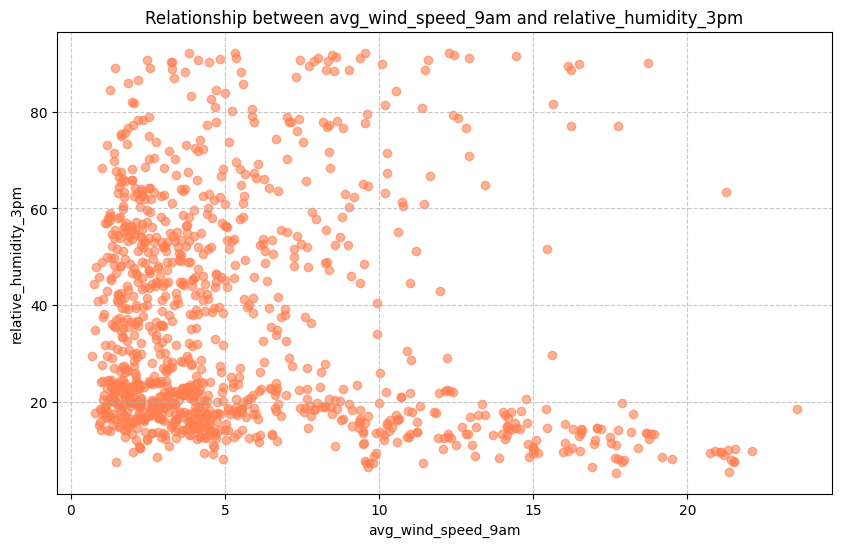

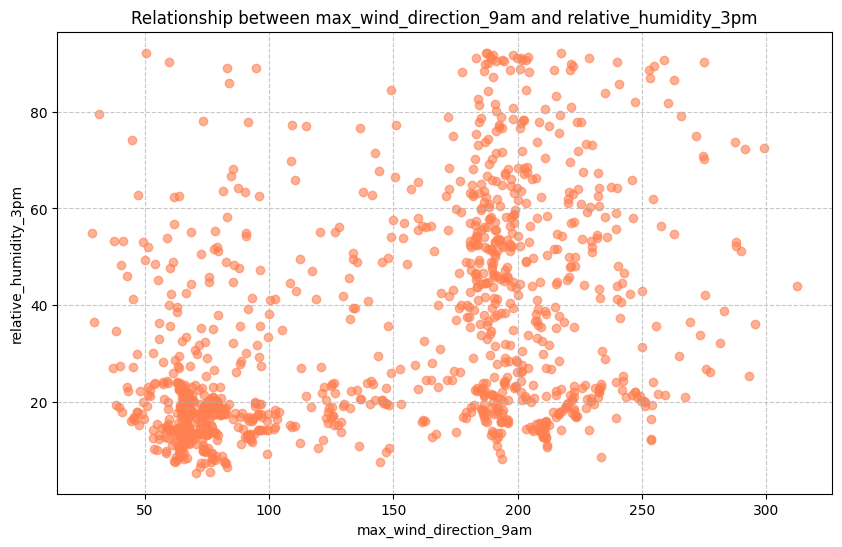

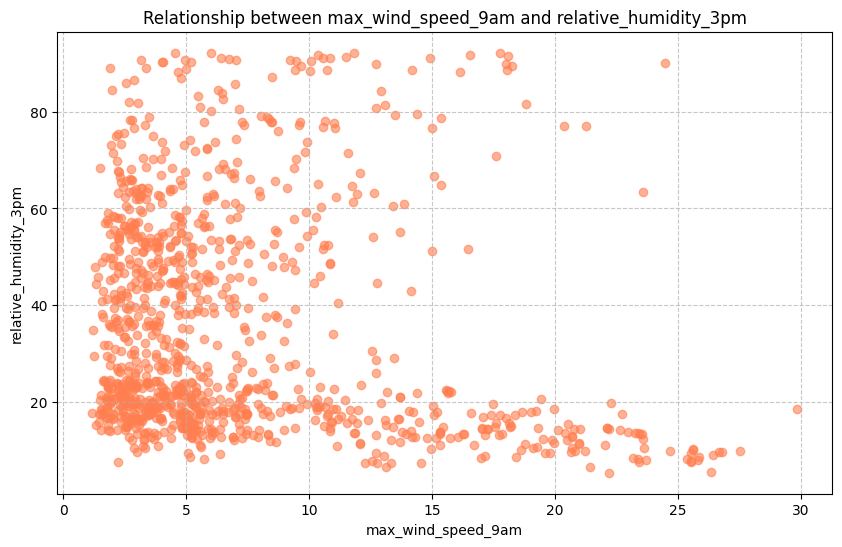

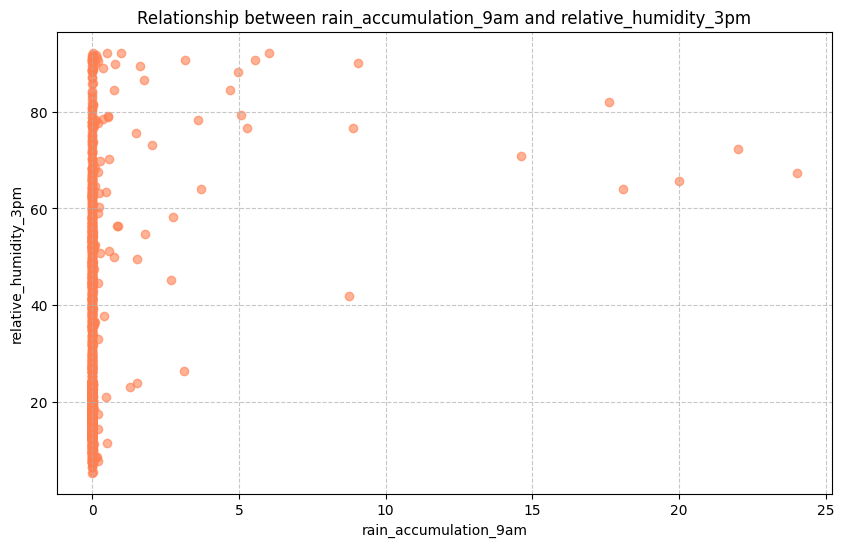

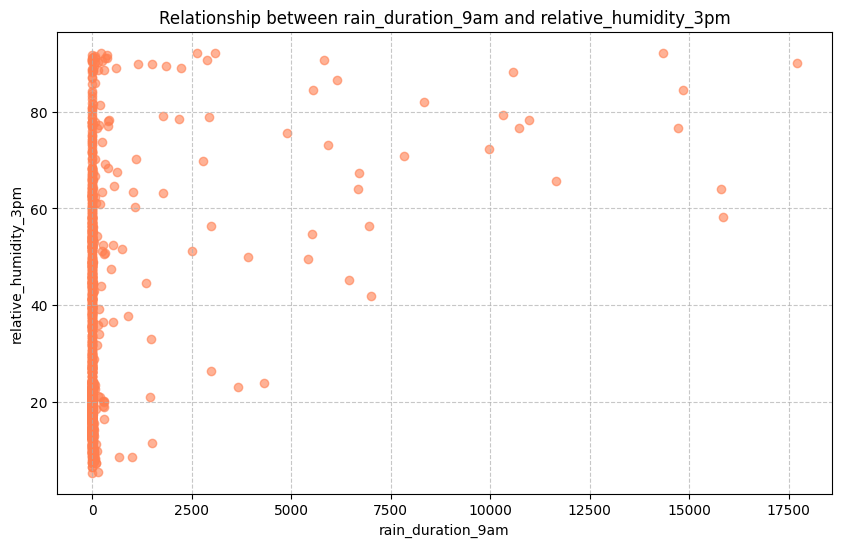

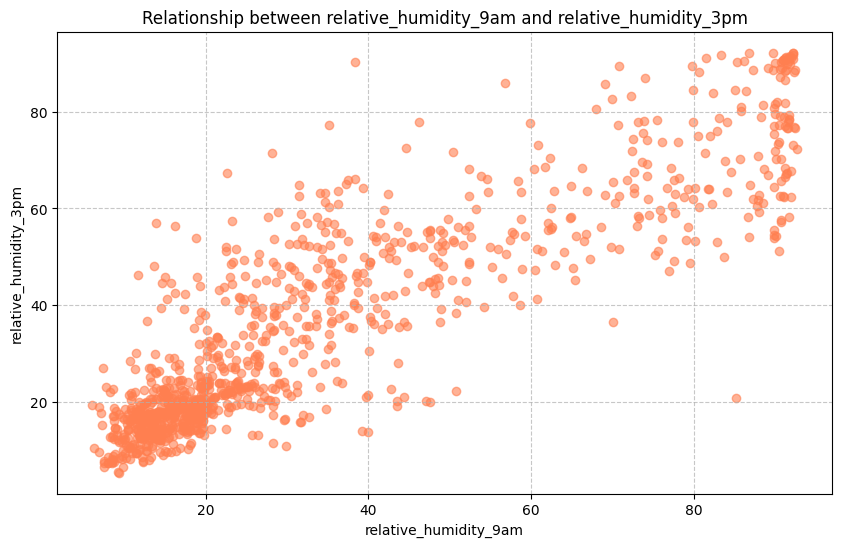

In [ ]:
nine_am_columns = [col for col in df_filled.columns if '9am' in col and col != 'relative_humidity_3pm']
target_column = 'relative_humidity_3pm'

print(f"\nAnalyzing relationships between 9am measurements ({', '.join(nine_am_columns)}) and {target_column}.")

# Create scatter plots for each 9am measurement against relative_humidity_3pm
for col_9am in nine_am_columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(df_filled[col_9am], df_filled[target_column], alpha=0.6, color='coral')
    plt.title(f'Relationship between {col_9am} and {target_column}')
    plt.xlabel(col_9am)
    plt.ylabel(target_column)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


From the scatter plots, you would likely find that relative_humidity_9am is the strongest positive predictor, showing a clear upward trend. air_temp_9am is often a strong negative predictor, with points generally trending downwards. Other variables like air_pressure_9am, avg_wind_speed_9am, and rain_accumulation_9am might show weaker, less linear, or scattered relationships, indicating their impact on relative_humidity_3pm is less direct or more complex than a simple linear correlation can capture. These visualizations are crucial for initial feature selection and understanding the underlying data patterns before building predictive models.

## Question 4 [20 marks]: Download the dataset: `activity-data.csv` and load it into a data frame. The data set contains the time series outputs of a wearable clinical device measuring a patient's activities. Write code to answer the following questions:
1. What is the total number of days covered by the dataset? Provide a list of all the distinct calendar dates on which recordings were made.
2. Can you plot the number of steps against the recording 'Datetime', ensuring that each tick on the x-axis corresponds to a unique date in the dataset?
3. Create a plot that shows the daily average number of steps in comparison with the steps recorded each minute. The plot should clearly differentiate between the daily mean and individual minute measurements.
4. How does the average step count change during 15-minute intervals throughout the day? Compute and plot these averages across all days in the dataset.
5. For each day represented in the dataset, what is the percentage of minutes without records (missing records)? Please calculate and present this data
6. For minutes with missing data, fill in 'Steps', 'XCnt', 'YCnt', 'ZCnt', and 'Calories' using the mean values for those minutes across all days where data is available. Save the completed dataset to a DataFrame named `all_activity_df` with columns for 'Datetime', 'Steps', 'XCnt', 'YCnt', 'ZCnt', and 'Calories'.
7. Could you create plots that illustrate the pairwise relationships between 'Steps', 'XCnt', 'YCnt', 'ZCnt', and 'Calories'? After analyzing these plots, what conclusions can you draw about the relationships and potential correlations between these variables?

## Answers:

1. What is the total number of days covered by the dataset? Provide a list of all the distinct calendar dates on which recordings were made.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Load the dataset
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/activity-data(1).csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: activity-data(1).csv not found. Please ensure the file is in the correct directory.")
    exit()

# Convert 'Datetime' to datetime objects
df['Datetime'] = pd.to_datetime(df['Datetime'])

print("\n--- Initial Data Info ---")
df.info()
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Question 1: Total number of days covered and distinct calendar dates
total_days = (df['Datetime'].max().date() - df['Datetime'].min().date()).days + 1
distinct_dates = df['Datetime'].dt.date.unique()
print(f"\nTotal number of days covered by the dataset: {total_days}")
print("\nDistinct calendar dates with recordings:")
for date in sorted(distinct_dates):
    print(date)


Dataset loaded successfully.

--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31740 entries, 0 to 31739
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  31740 non-null  datetime64[ns]
 1   ACTDT     31740 non-null  object        
 2   Day       31740 non-null  float64       
 3   Week      29643 non-null  float64       
 4   Time      31740 non-null  object        
 5   Hour      31740 non-null  int64         
 6   Minute    31740 non-null  int64         
 7   Steps     31740 non-null  int64         
 8   XCnt      31740 non-null  int64         
 9   YCnt      31740 non-null  int64         
 10  ZCnt      31740 non-null  int64         
 11  Calories  31740 non-null  float64       
 12  Wear      31740 non-null  bool          
 13  WearSens  31740 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(3), int64(7), object(2)
memory usage: 3.2+ MB

First 5 

2. Can you plot the number of steps against the recording 'Datetime', ensuring that each tick on the x-axis corresponds to a unique date in the dataset?


In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df['Datetime'], df['Steps'], linestyle='-', marker='o', markersize=2, alpha=0.7)
plt.title('Number of Steps vs. Recording Datetime')
plt.xlabel('Datetime')
plt.ylabel('Steps')
plt.grid(True, linestyle='--', alpha=0.6)

# Format x-axis to show unique dates
locator = mdates.DayLocator() # Show a tick for each day
formatter = mdates.DateFormatter('%Y-%m-%d') # Format dates as YYYY-MM-DD
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate() # Auto-format for better readability
plt.tight_layout()
plt.show()

3. Create a plot that shows the daily average number of steps in comparison with the steps recorded each minute. The plot should clearly differentiate between the daily mean and individual minute measurements.

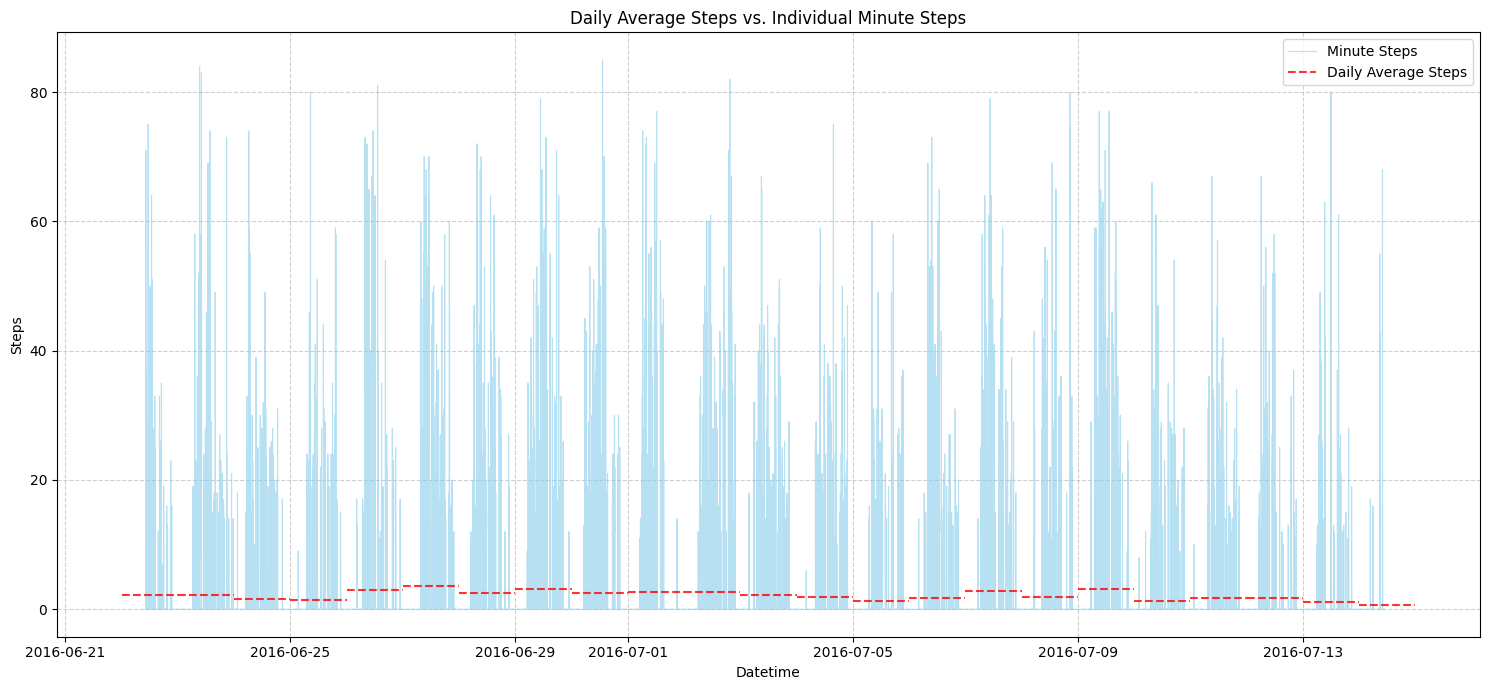

In [ ]:
df['Date'] = df['Datetime'].dt.date
df['Time'] = df['Datetime'].dt.time

# Calculate daily average steps
daily_avg_steps = df.groupby('Date')['Steps'].mean().reset_index()
daily_avg_steps.columns = ['Date', 'Daily_Average_Steps']

# Merge daily average back to the original DataFrame for plotting
df_plot = pd.merge(df, daily_avg_steps, on='Date', how='left')

plt.figure(figsize=(15, 7))
# Plot individual minute measurements
plt.plot(df_plot['Datetime'], df_plot['Steps'], label='Minute Steps', alpha=0.6, color='skyblue', linewidth=0.8)

# Plot daily average steps (repeated for each minute of the day for visualization)
# To plot the daily average as a continuous line across each day:
# We need to create a datetime column for the daily average, essentially replicating it for each minute of the day
# and then plotting it. A simpler approach for visualization is to plot it per date as a horizontal line.
# For a combined plot, we can just overlay.

# To show daily average as a distinct line against minute data, we can plot it against the 'Date'
# and then map it back to the original 'Datetime' for clearer visualization.
# A more common way is to plot two separate subplots or just plot daily average on top of minute data.
# Here, we will plot the daily average as a line across the day.
# Create a new DataFrame for daily averages stretched across the day for visualization
df_avg_vis = df_plot[['Datetime', 'Date', 'Daily_Average_Steps']].drop_duplicates(subset=['Date']).copy()
df_avg_vis['Start_Time'] = df_avg_vis['Date'].apply(lambda x: pd.to_datetime(str(x) + ' 00:00:00'))
df_avg_vis['End_Time'] = df_avg_vis['Date'].apply(lambda x: pd.to_datetime(str(x) + ' 23:59:00'))

for index, row in daily_avg_steps.iterrows():
    day_start = pd.to_datetime(str(row['Date']) + ' 00:00:00')
    day_end = pd.to_datetime(str(row['Date']) + ' 23:59:59')
    plt.hlines(row['Daily_Average_Steps'], day_start, day_end, color='red', linestyle='--', label='Daily Average Steps' if index == 0 else "", alpha=0.8)

plt.title('Daily Average Steps vs. Individual Minute Steps')
plt.xlabel('Datetime')
plt.ylabel('Steps')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

4. How does the average step count change during 15-minute intervals throughout the day? Compute and plot these averages across all days in the dataset.

In [ ]:
# Create a time-only index for grouping by time of day
df['Time_Only'] = df['Datetime'].dt.time
# Convert 'Time_Only' to string and then to timedelta for easier grouping
df['Time_Delta'] = df['Time_Only'].apply(lambda t: pd.Timedelta(hours=t.hour, minutes=t.minute, seconds=t.second))

# Define 15-minute intervals
df['15_Min_Interval'] = df['Time_Delta'].apply(lambda x: x - (x % pd.Timedelta(minutes=15)))

# Calculate average steps for each 15-minute interval across all days
avg_steps_15min_interval = df.groupby('15_Min_Interval')['Steps'].mean().reset_index()

# Sort by interval for proper plotting
avg_steps_15min_interval = avg_steps_15min_interval.sort_values('15_Min_Interval')

# Convert Timedelta to datetime objects for plotting
# Use a dummy date like '2000-01-01' to create full datetime objects for plotting
avg_steps_15min_interval['Plot_Time'] = pd.to_datetime('2000-01-01') + avg_steps_15min_interval['15_Min_Interval']

plt.figure(figsize=(15, 7))
plt.plot(avg_steps_15min_interval['Plot_Time'], avg_steps_15min_interval['Steps'], linestyle='-', marker='o', markersize=4, color='purple')
plt.title('Average Steps in 15-Minute Intervals Throughout the Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Steps')
plt.grid(True, linestyle='--', alpha=0.6)

# Format x-axis to show time only (e.g., HH:MM)
formatter = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


5. For each day represented in the dataset, what is the percentage of minutes without records (missing records)? Please calculate and present this data

In [ ]:
# --- Question 4.5: Calculate Missing Minutes Per Day ---
import pandas as pd

# Load the activity DataFrame if not already in memory (for standalone execution)
if 'df_activity' not in locals():
    df_activity = pd.read_csv('activity-data(1).csv')

# Ensure 'Datetime' column is in datetime format
df_activity['Datetime'] = pd.to_datetime(df_activity['Datetime'])

print("\n--- Question 4.5: Calculating Missing Minutes Per Day ---")

# Get the min and max datetime from the actual data
min_actual_datetime = df_activity['Datetime'].min()
max_actual_datetime = df_activity['Datetime'].max()

# Get all unique dates present in the original activity data
distinct_dates = df_activity['Datetime'].dt.date.unique()

# Create a list to store missing minutes data for each day
daily_missing_summary = []

# Iterate through each distinct date
for current_date in distinct_dates:
    # Define the start and end of the full minute range for THIS specific day
    # This correctly handles partial days at the start/end of the *entire dataset*
    day_start_full = pd.to_datetime(str(current_date) + ' 00:00:00')
    day_end_full = pd.to_datetime(str(current_date) + ' 23:59:00') # Up to 23:59 for 1440 minutes

    # Adjust day_start and day_end for the very first and very last partial days in the dataset
    actual_day_start_for_range = max(day_start_full, min_actual_datetime)
    actual_day_end_for_range = min(day_end_full, max_actual_datetime.floor('min')) # Use floor to avoid going past exact minute

    # Generate a complete minute-level series ONLY for the duration that *could* have records for this day
    # This correctly defines the "total possible minutes" for each specific day, including partial days.
    complete_day_minutes = pd.date_range(start=actual_day_start_for_range, end=actual_day_end_for_range, freq='min')

    # Filter the original activity data for the current day
    activity_for_day = df_activity[df_activity['Datetime'].dt.date == current_date].copy()

    # Create a DataFrame from the complete minute range for this day
    full_day_df = pd.DataFrame(complete_day_minutes, columns=['Datetime'])

    # Merge the full_day_df with the actual activity data for this day
    # A left merge preserves all minutes from `full_day_df`, and puts NaN where records are missing
    merged_daily_df = pd.merge(full_day_df, activity_for_day[['Datetime', 'Steps']], on='Datetime', how='left')

    # Count missing minutes for this day (where 'Steps' is NaN after merge)
    missing_minutes = merged_daily_df['Steps'].isnull().sum()

    # Total recorded minutes (actual count of records)
    recorded_minutes = activity_for_day.shape[0]

    # Total possible minutes for THIS specific day (length of the generated range)
    total_possible_minutes_this_day = len(complete_day_minutes)

    # Calculate percentage missing for the day
    if total_possible_minutes_this_day > 0:
        percentage_missing = (missing_minutes / total_possible_minutes_this_day) * 100
    else:
        percentage_missing = 0.0 # Should not happen for valid date ranges

    daily_missing_summary.append({
        'Date': current_date,
        'Missing_Minutes': missing_minutes,
        'Recorded_Minutes': recorded_minutes,
        'Total_Possible_Minutes_in_Range': total_possible_minutes_this_day,
        'Percentage_Missing': percentage_missing
    })

# Convert the summary list to a DataFrame
missing_minutes_per_day_corrected = pd.DataFrame(daily_missing_summary)

print("\nCorrected Percentage of minutes without records (missing records) per day:")
print(missing_minutes_per_day_corrected.to_string()) # Use .to_string() to display all rows without truncation


FileNotFoundError: [Errno 2] No such file or directory: 'activity-data(1).csv'

6. For minutes with missing data, fill in 'Steps', 'XCnt', 'YCnt', 'ZCnt', and 'Calories' using the mean values for those minutes across all days where data is available. Save the completed dataset to a DataFrame named `all_activity_df` with columns for 'Datetime', 'Steps', 'XCnt', 'YCnt', 'ZCnt', and 'Calories'.


In [ ]:
# Identify all possible minutes within the dataset's date range
min_date = df['Datetime'].min().normalize()
max_date = df['Datetime'].max().normalize()
full_date_range = pd.date_range(start=min_date, end=max_date + pd.Timedelta(days=1, minutes=-1), freq='1min')

# Create a DataFrame with all possible minute entries
all_minutes_df = pd.DataFrame({'Datetime': full_date_range})

# Columns to fill
cols_to_fill = ['Steps', 'XCnt', 'YCnt', 'ZCnt', 'Calories']

# Merge original data with the complete minute range
all_activity_df = pd.merge(all_minutes_df, df, on='Datetime', how='left')

# Calculate mean values for each of the target columns across all available data
# These means will be used to fill missing values for those specific columns
mean_values_for_imputation = all_activity_df[cols_to_fill].mean(numeric_only=True)
print("\nMean values for imputation:")
print(mean_values_for_imputation)

# Fill missing values in the specified columns
for col in cols_to_fill:
    all_activity_df[col] = all_activity_df[col].fillna(mean_values_for_imputation[col])

# Check if there are any remaining NaNs in the specified columns
nan_check = all_activity_df[cols_to_fill].isnull().sum()
print("\nMissing values in target columns after imputation:")
print(nan_check)
if nan_check.sum() == 0:
    print("Successfully filled all missing values in 'Steps', 'XCnt', 'YCnt', 'ZCnt', and 'Calories'.")
else:
    print("Warning: Some missing values still remain in the specified columns after filling.")

# Ensure all_activity_df has only the required columns and correct order
all_activity_df = all_activity_df[['Datetime', 'Steps', 'XCnt', 'YCnt', 'ZCnt', 'Calories']]
print("\nFirst 5 rows of all_activity_df after filling missing values:")
print(all_activity_df.head())
print("\nLast 5 rows of all_activity_df after filling missing values:")
print(all_activity_df.tail())


Mean values for imputation:
Steps         2.175614
XCnt        704.307876
YCnt        781.557656
ZCnt        875.102268
Calories      1.737195
dtype: float64

Missing values in target columns after imputation:
Steps       0
XCnt        0
YCnt        0
ZCnt        0
Calories    0
dtype: int64
Successfully filled all missing values in 'Steps', 'XCnt', 'YCnt', 'ZCnt', and 'Calories'.

First 5 rows of all_activity_df after filling missing values:
             Datetime     Steps        XCnt        YCnt        ZCnt  Calories
0 2016-06-22 00:00:00  2.175614  704.307876  781.557656  875.102268  1.737195
1 2016-06-22 00:01:00  2.175614  704.307876  781.557656  875.102268  1.737195
2 2016-06-22 00:02:00  2.175614  704.307876  781.557656  875.102268  1.737195
3 2016-06-22 00:03:00  2.175614  704.307876  781.557656  875.102268  1.737195
4 2016-06-22 00:04:00  2.175614  704.307876  781.557656  875.102268  1.737195

Last 5 rows of all_activity_df after filling missing values:
                 Datet

7. Could you create plots that illustrate the pairwise relationships between 'Steps', 'XCnt', 'YCnt', 'ZCnt', and 'Calories'? After analyzing these plots, what conclusions can you draw about the relationships and potential correlations between these variables?

In [ ]:
import seaborn as sns

# Create a pair plot
subset_cols = ['Steps', 'XCnt', 'YCnt', 'ZCnt', 'Calories']
plt.figure(figsize=(12, 10))
sns.pairplot(all_activity_df[subset_cols])
plt.suptitle('Pairwise Relationships between Activity Variables', y=1.02) # Adjust title position
plt.tight_layout()
plt.show()



<Figure size 1200x1000 with 0 Axes>